# Train on generated datasets

In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import time
import datetime
import json
import pickle
import os

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras import optimizers
from keras.utils.vis_utils import plot_model
from keras.callbacks import LearningRateScheduler
from keras.layers.normalization import BatchNormalization
from keras import regularizers

from tensorflow.keras import Input
from tensorflow.keras import Model
from tcn import TCN

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

from utils import *
from models import *
import config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
STUDY_PATH = config.STUDY_PATH
GEN_DFS_PATH = config.GEN_DFS_PATH
TRAIN_VAL_RATIO = config.TRAIN_VAL_RATIO
N_STEPS = config.N_STEPS
N_FEATURES_IN = config.N_FEATURES_IN
N_FEATURES_OUT = config.N_FEATURES_OUT
TPL_PATH = config.TPL_PATH

n_input = N_STEPS * N_FEATURES_IN
err_upper_limit = 14
pd.options.display.max_columns = 25

In [8]:
TPL_PATH

'C:\\Users\\Asus\\Desktop\\Skoltech\\Multiphase flows\\olga_proj\\Subsea_Study[7]'

In [34]:
# load datasets

dfs = []
inputss = []
outputss = []
out_names = ['BORE_OIL_VOL', 'BORE_GAS_VOL', 'BORE_WAT_VOL']

for file in os.listdir(GEN_DFS_PATH):
    df = pd.read_csv(f'{GEN_DFS_PATH}/{file}')
#     if df.shape[0] >= N_STEPS * 4:
    if df.shape[0] >= 50:
        outputs = df[out_names]
        inputs = df.drop(columns=out_names, axis=1)

        dfs.append(df)
        inputss.append(inputs)
        outputss.append(outputs)

In [35]:
# print number of valid files

tpl_files = list_ext(TPL_PATH, 'tpl')

print (f'{len(dfs)} out of {len(os.listdir(GEN_DFS_PATH))} ({np.round(len(dfs)/len(os.listdir(GEN_DFS_PATH))*100, 1)}%) without errors')
print (f'which means')
print (f'{len(dfs)} out of {len(tpl_files)} ({np.round(len(dfs)/len(tpl_files)*100, 1)}%) without errors total')

395 out of 478 (82.6%) without errors
which means
395 out of 551 (71.7%) without errors total


# MLP

(MSE, 3 layers, 100 neurons, do=0.2, lr=1e-4, epochs=500)

In [39]:
MODEL_NAME = 'MLP-1'
LOSS = 'mse'

In [40]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 500
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 500
    import tensorflow.keras.optimizers
    batch_x = 17
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=50, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, max_depth=5, reg_alpha=1))

In [41]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [42]:
def scheduler(epoch, lr):
    if epoch < 25:
        return 1e-3
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 1e-5
    else:
        return 1e-6

callback = LearningRateScheduler(scheduler)

In [43]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
    shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
    model_inf = model.fit(X_train_shuffle[:shape_train], y_train_shuffle[:shape_train], epochs=n_epochs, verbose=1, validation_data=(X_valid[:shape_test], y_valid[:shape_test]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_reshaped, y)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, callbacks=[callback], batch_size=128, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Train on 19748 samples, validate on 2747 samples
Epoch 1/500
19748/19748 [==============================] - 1s 71us/step - loss: 0.1558 - val_loss: 0.0369
Epoch 2/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0616 - val_loss: 0.0326
Epoch 3/500
19748/19748 [==============================] - 1s 53us/step - loss: 0.0527 - val_loss: 0.0315
Epoch 4/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0486 - val_loss: 0.0307
Epoch 5/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0453 - val_loss: 0.0311
Epoch 6/500
19748/19748 [==============================] - 1s 53us/step - loss: 0.0434 - val_loss: 0.0287
Epoch 7/500
19748/19748 [==============================] - 1s 54us/step - loss: 0.0411 - val_loss: 0.0316
Epoch 8/500
19748/19748 [==============================] - 1s 54us/step - loss: 0.0393 - val_loss: 0.0266
Epoch 9/500
19748/19748 [==============================] - 1s 53us/step - loss: 0.0373 - val_loss: 0.02

19748/19748 [==============================] - 1s 53us/step - loss: 0.0238 - val_loss: 0.0200
Epoch 153/500
19748/19748 [==============================] - 1s 53us/step - loss: 0.0240 - val_loss: 0.0195
Epoch 154/500
19748/19748 [==============================] - 1s 59us/step - loss: 0.0237 - val_loss: 0.0206
Epoch 155/500
19748/19748 [==============================] - 1s 56us/step - loss: 0.0238 - val_loss: 0.0194
Epoch 156/500
19748/19748 [==============================] - 1s 57us/step - loss: 0.0237 - val_loss: 0.0191
Epoch 157/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0238 - val_loss: 0.0198
Epoch 158/500
19748/19748 [==============================] - 1s 56us/step - loss: 0.0237 - val_loss: 0.0181
Epoch 159/500
19748/19748 [==============================] - 1s 54us/step - loss: 0.0236 - val_loss: 0.0196
Epoch 160/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0236 - val_loss: 0.0198
Epoch 161/500
19748/19748 [===============

Epoch 228/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0232 - val_loss: 0.0190
Epoch 229/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0230 - val_loss: 0.0176
Epoch 230/500
19748/19748 [==============================] - 1s 55us/step - loss: 0.0232 - val_loss: 0.0181
Epoch 231/500
19748/19748 [==============================] - 1s 56us/step - loss: 0.0231 - val_loss: 0.0177
Epoch 232/500
19748/19748 [==============================] - 1s 60us/step - loss: 0.0229 - val_loss: 0.0202
Epoch 233/500
19748/19748 [==============================] - 1s 56us/step - loss: 0.0231 - val_loss: 0.0174
Epoch 234/500
19748/19748 [==============================] - 1s 57us/step - loss: 0.0232 - val_loss: 0.0176
Epoch 235/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0233 - val_loss: 0.0184
Epoch 236/500
19748/19748 [==============================] - 1s 56us/step - loss: 0.0231 - val_loss: 0.0195
Epoch 237/500
19748/19748 [=

Epoch 379/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0224 - val_loss: 0.0170
Epoch 380/500
19748/19748 [==============================] - 1s 59us/step - loss: 0.0220 - val_loss: 0.0171
Epoch 381/500
19748/19748 [==============================] - 1s 57us/step - loss: 0.0220 - val_loss: 0.0171
Epoch 382/500
19748/19748 [==============================] - 1s 56us/step - loss: 0.0222 - val_loss: 0.0183
Epoch 383/500
19748/19748 [==============================] - 1s 57us/step - loss: 0.0226 - val_loss: 0.0186
Epoch 384/500
19748/19748 [==============================] - 1s 57us/step - loss: 0.0224 - val_loss: 0.0176
Epoch 385/500
19748/19748 [==============================] - 1s 55us/step - loss: 0.0224 - val_loss: 0.0182
Epoch 386/500
19748/19748 [==============================] - 1s 59us/step - loss: 0.0222 - val_loss: 0.0181
Epoch 387/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0222 - val_loss: 0.0176
Epoch 388/500
19748/19748 [=

Epoch 455/500
19748/19748 [==============================] - 1s 54us/step - loss: 0.0220 - val_loss: 0.0181
Epoch 456/500
19748/19748 [==============================] - 1s 59us/step - loss: 0.0218 - val_loss: 0.0170
Epoch 457/500
19748/19748 [==============================] - 1s 59us/step - loss: 0.0218 - val_loss: 0.0185
Epoch 458/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0218 - val_loss: 0.0184
Epoch 459/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0218 - val_loss: 0.0195
Epoch 460/500
19748/19748 [==============================] - 1s 55us/step - loss: 0.0217 - val_loss: 0.0168
Epoch 461/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0218 - val_loss: 0.0175
Epoch 462/500
19748/19748 [==============================] - 1s 57us/step - loss: 0.0220 - val_loss: 0.0177
Epoch 463/500
19748/19748 [==============================] - 1s 59us/step - loss: 0.0220 - val_loss: 0.0178
Epoch 464/500
19748/19748 [=

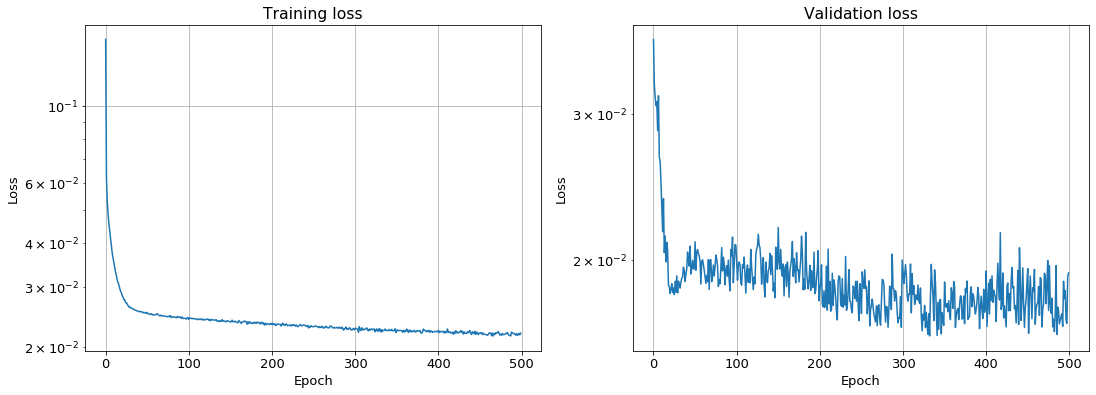

In [44]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

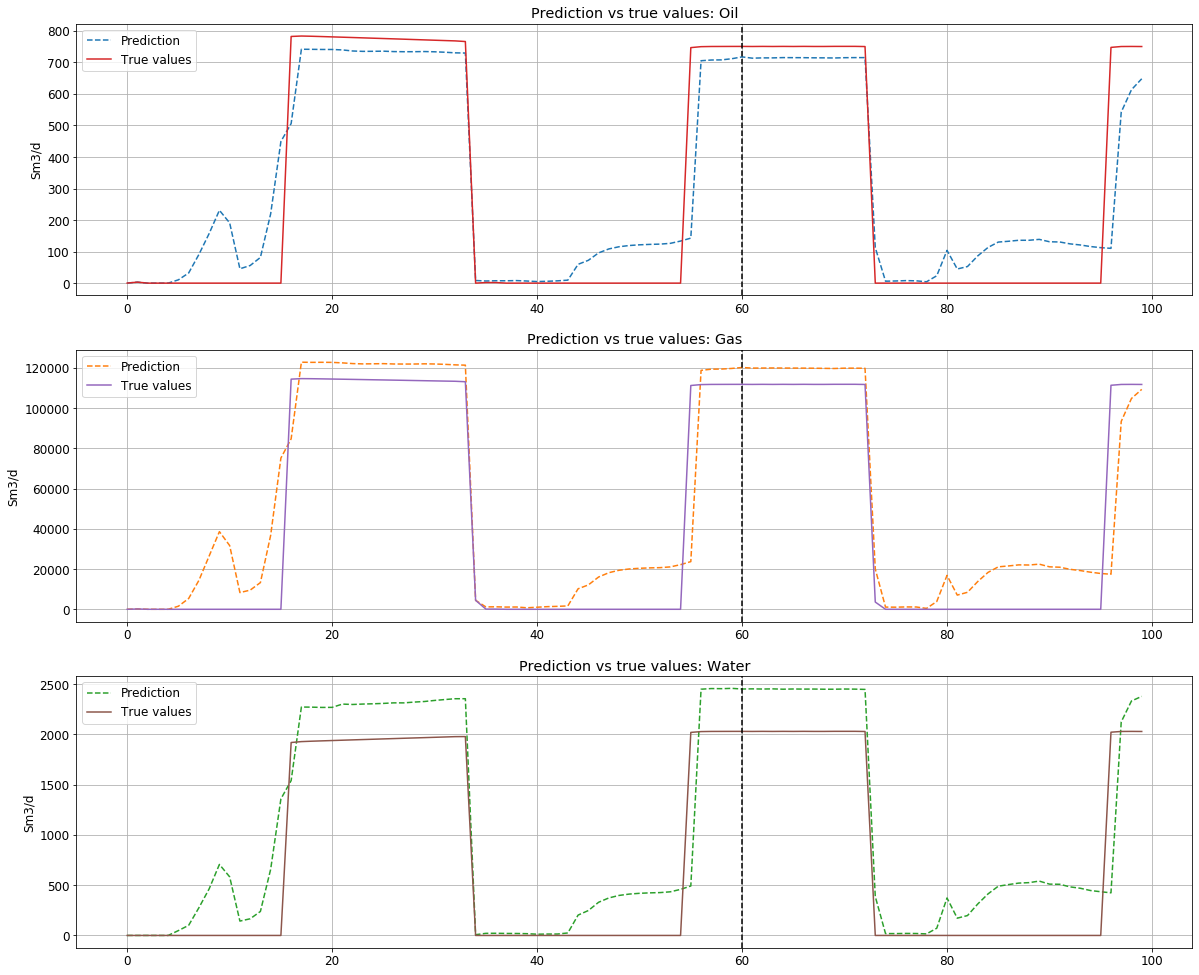

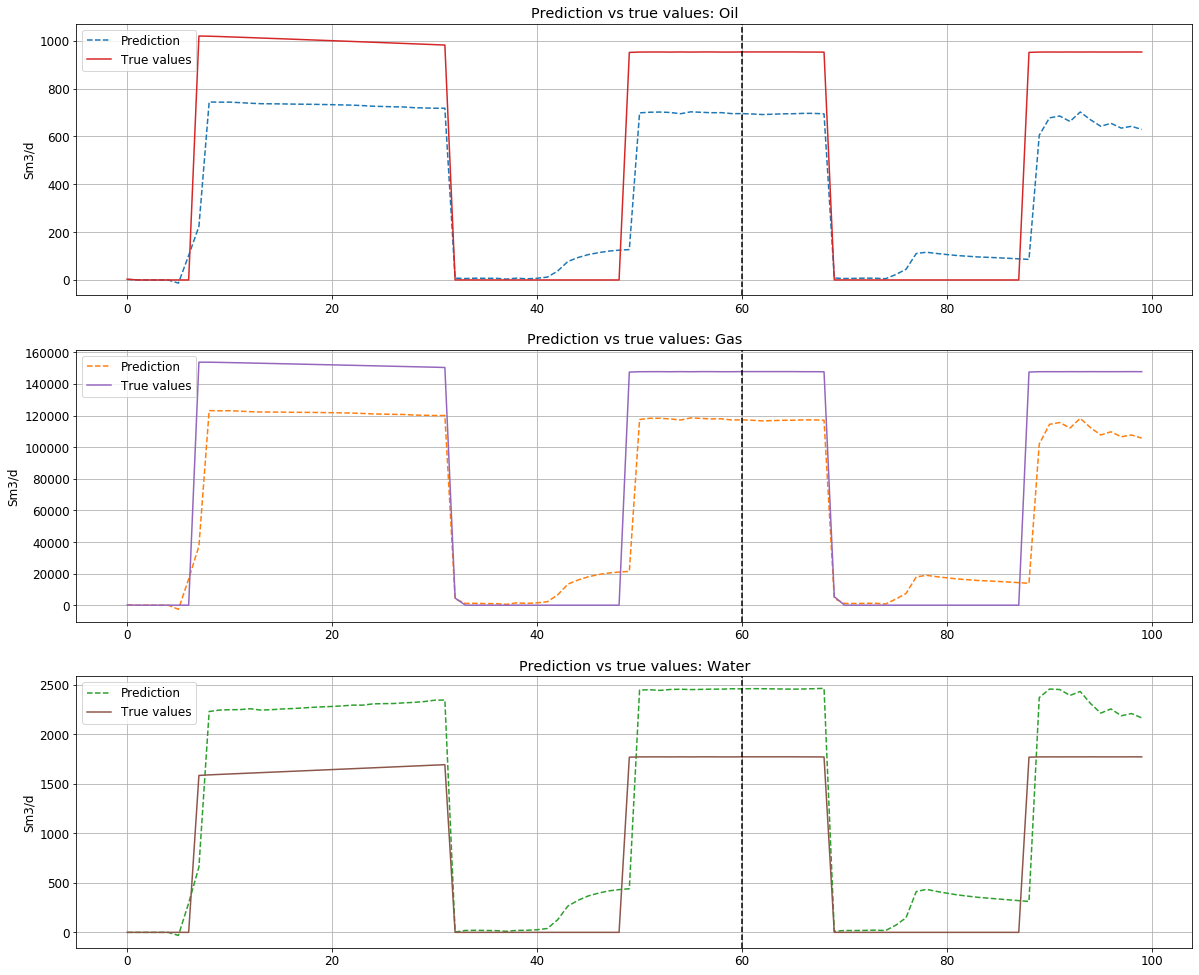

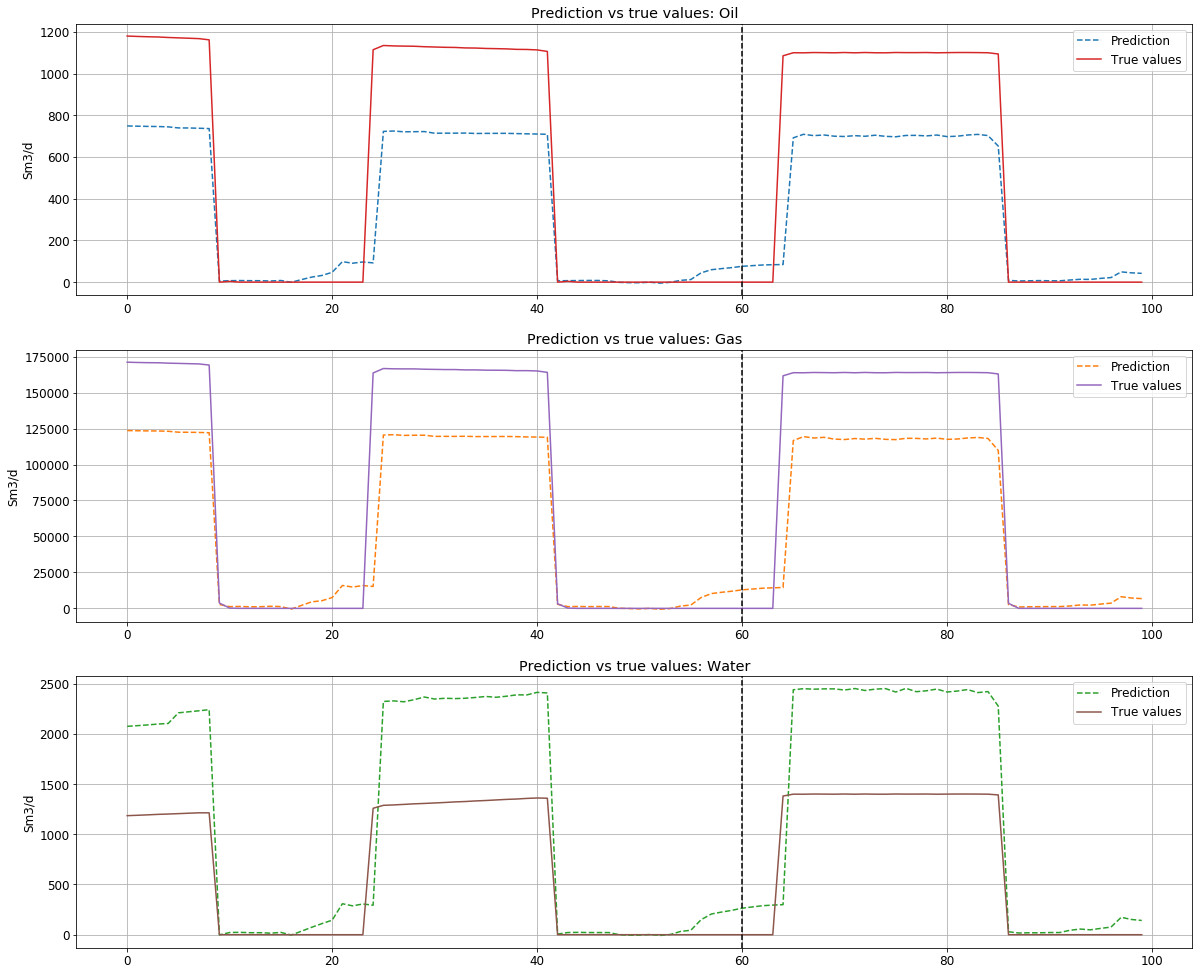

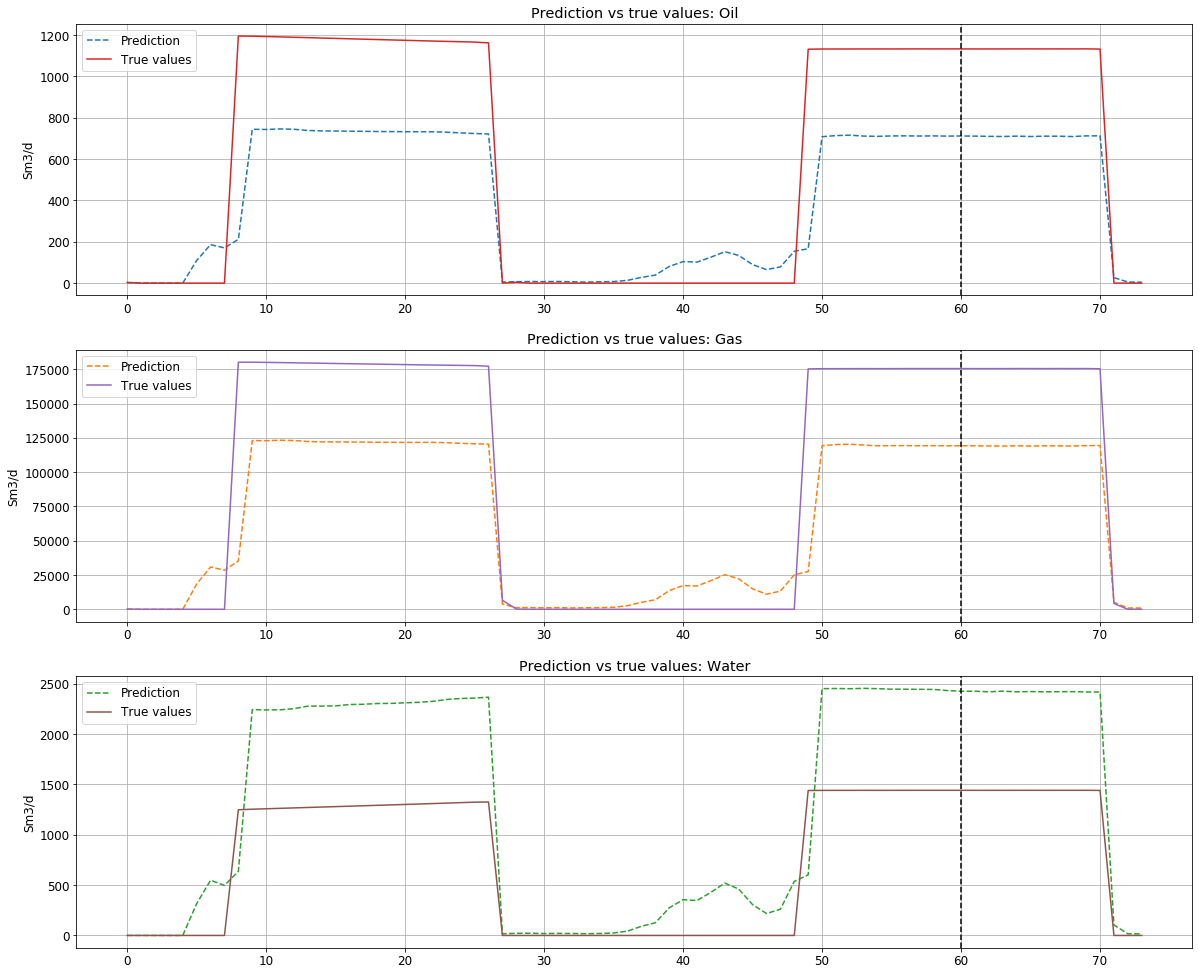

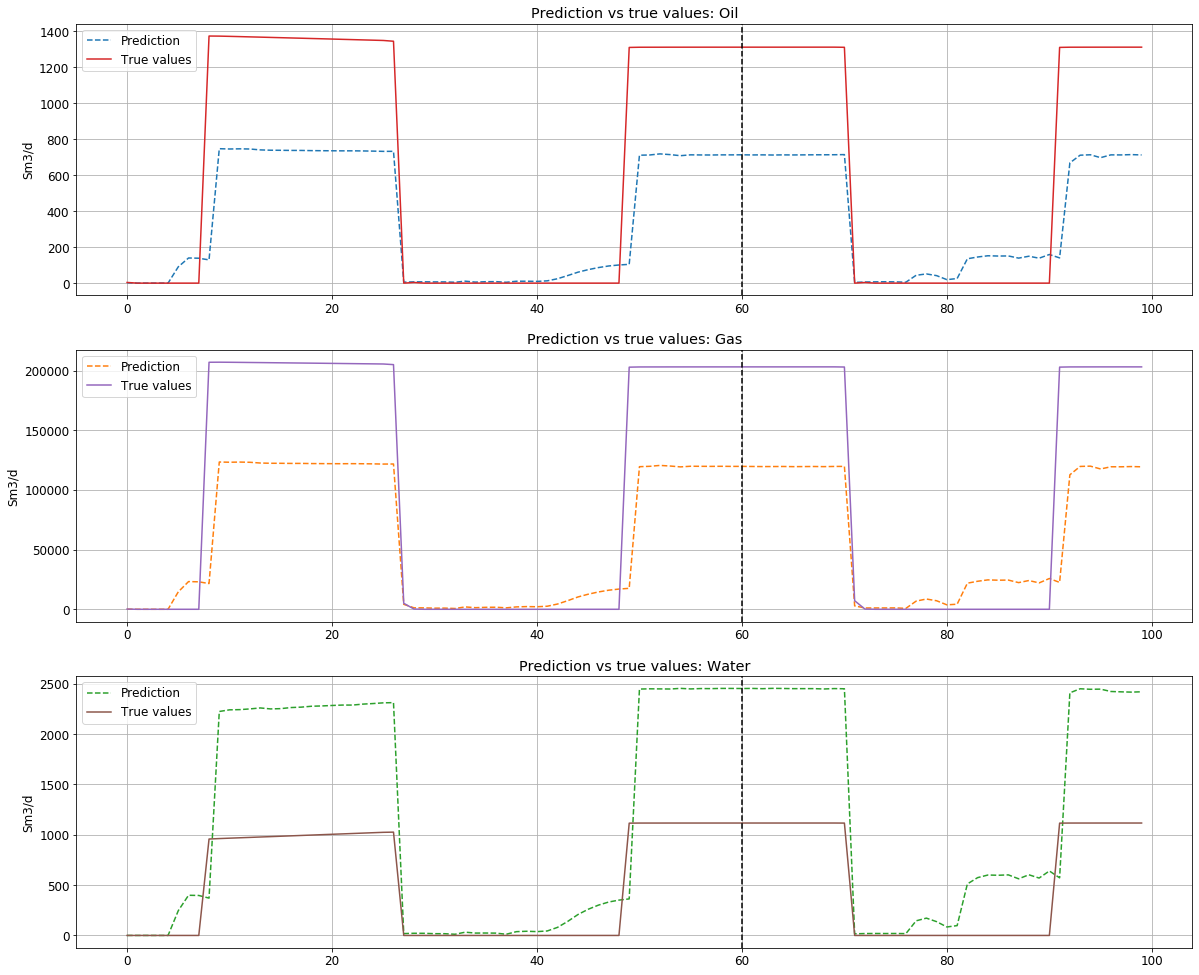

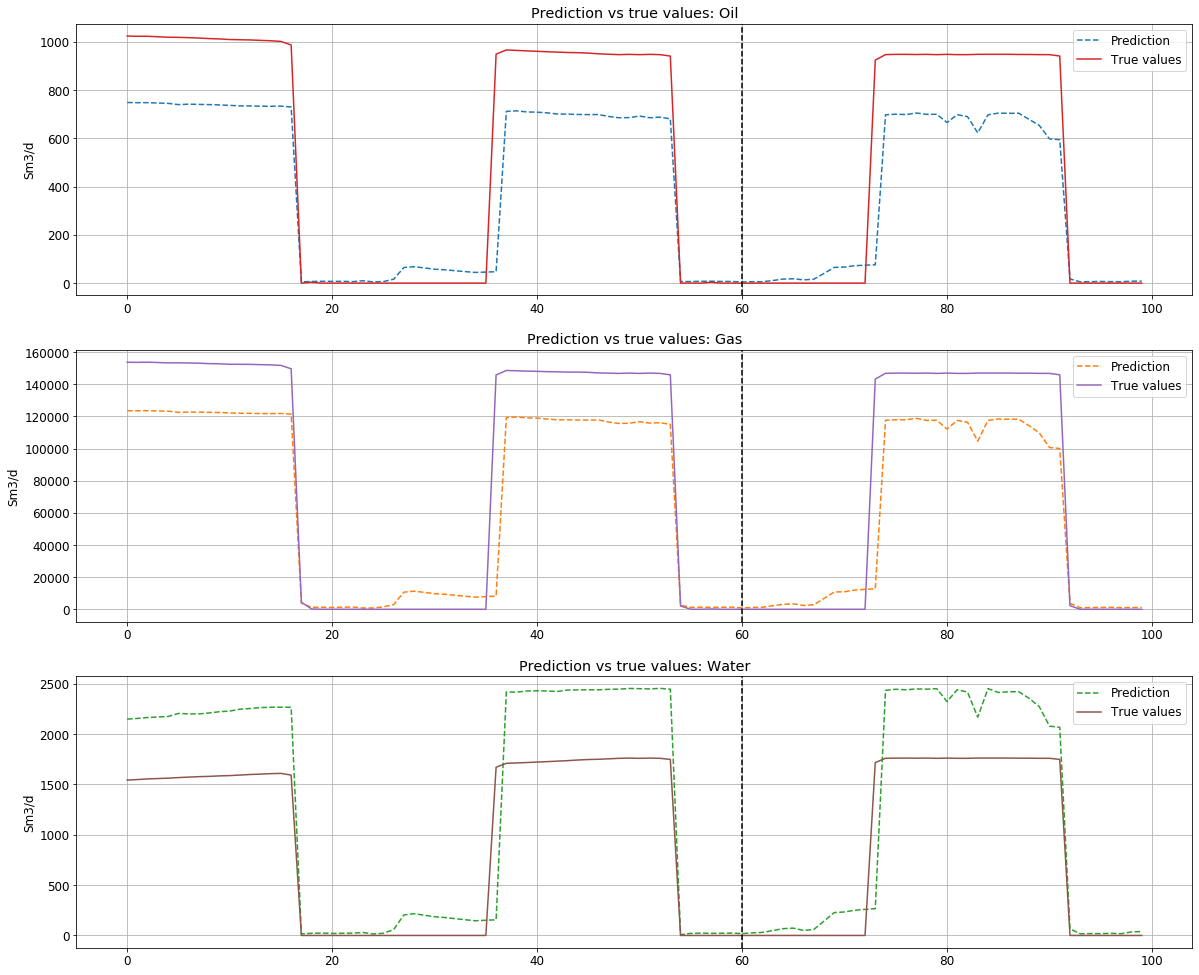

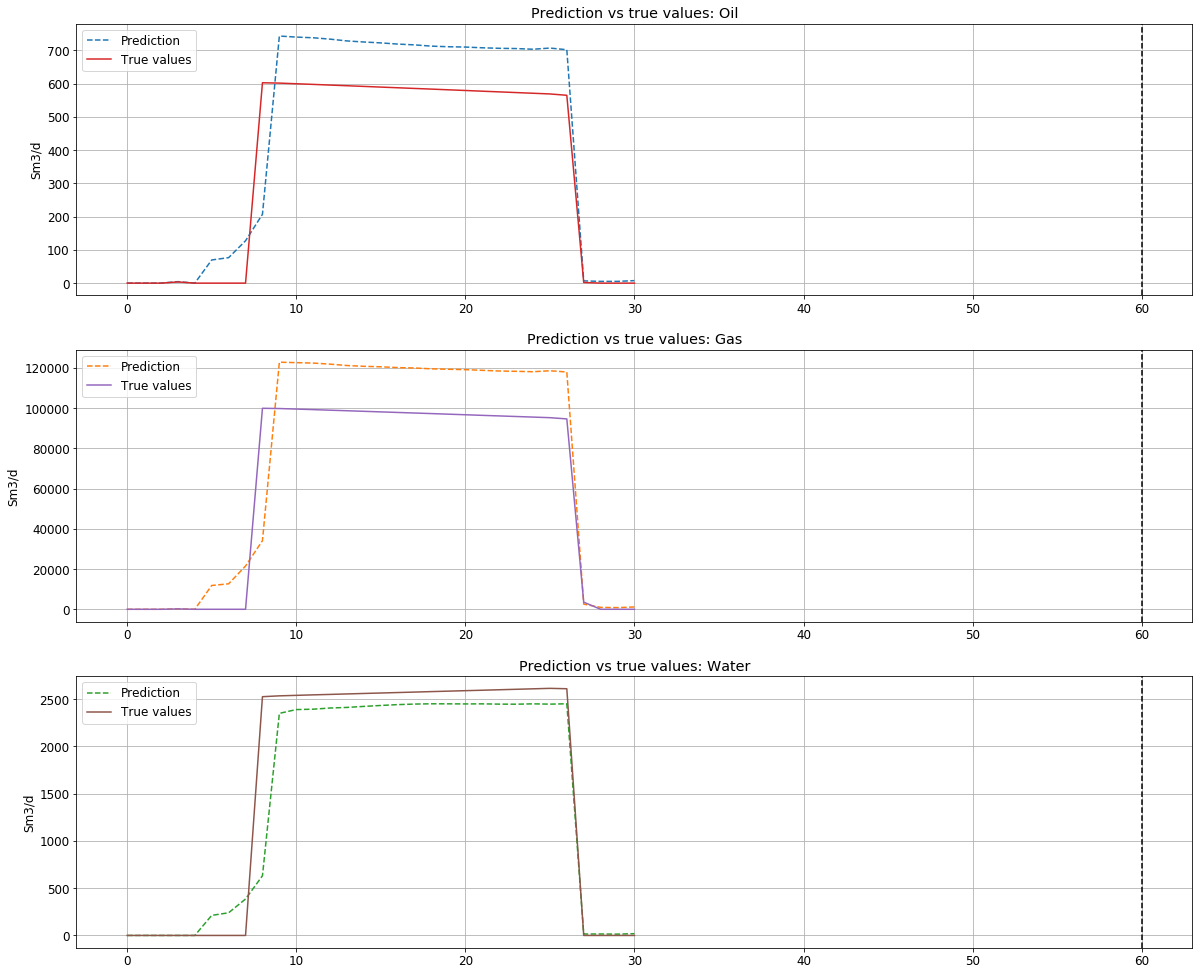

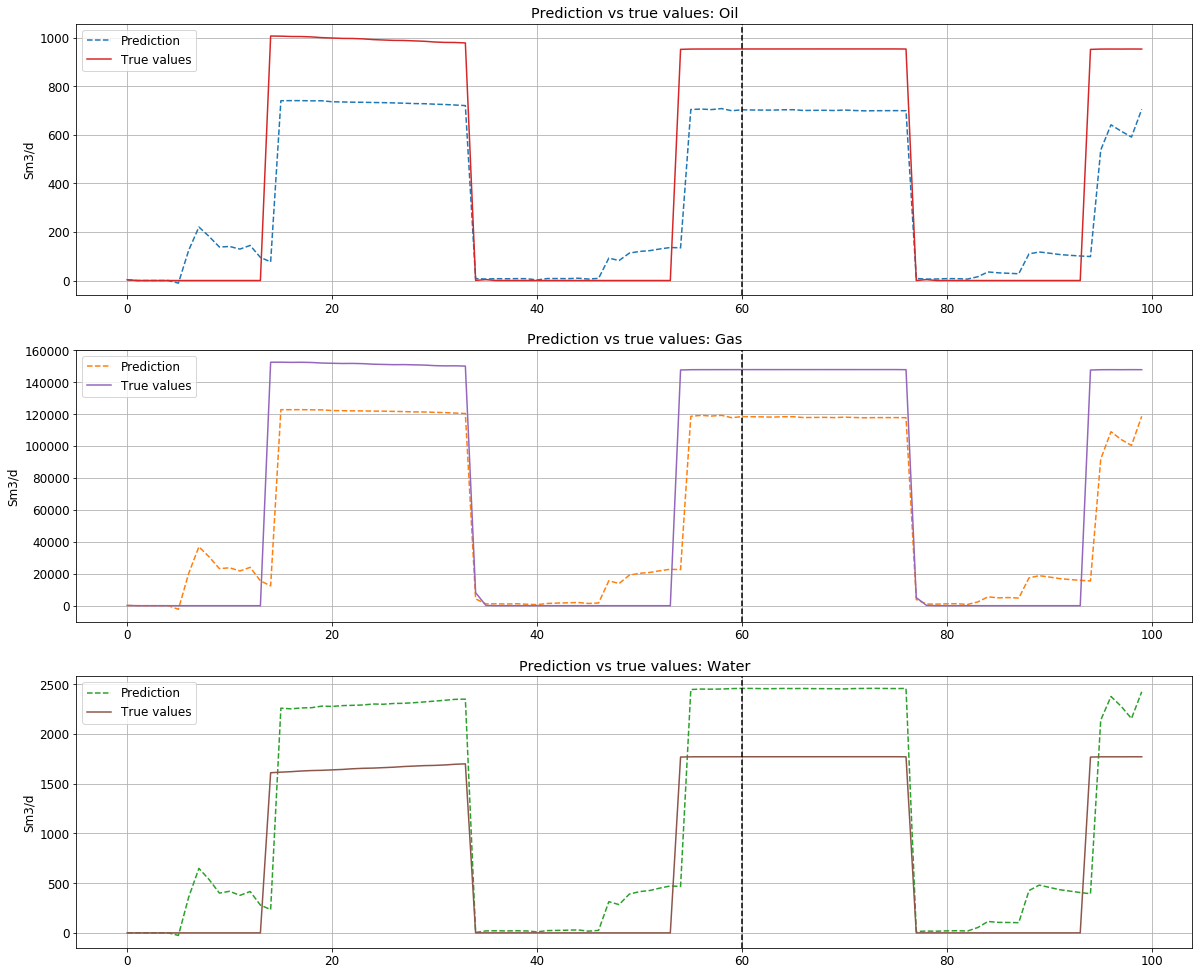

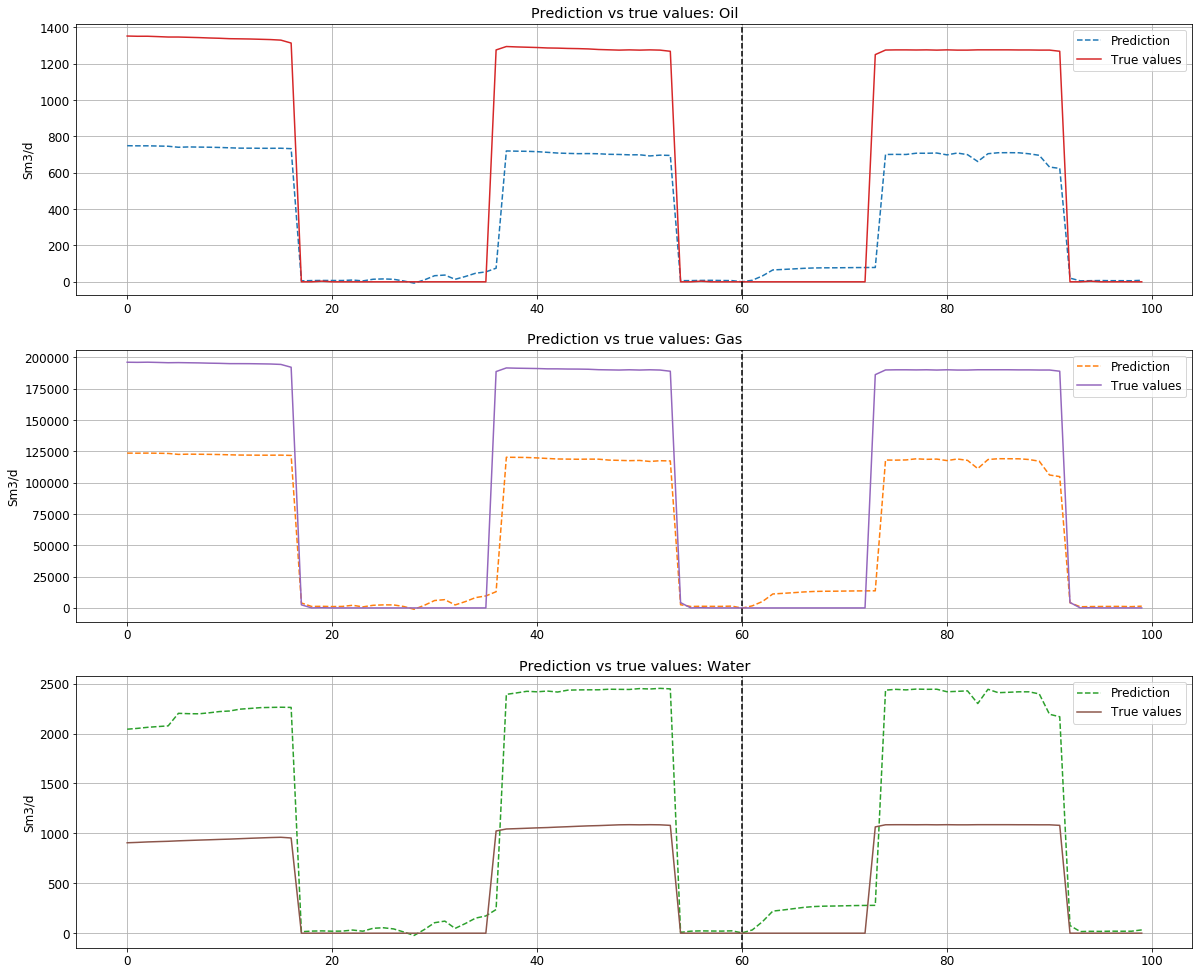

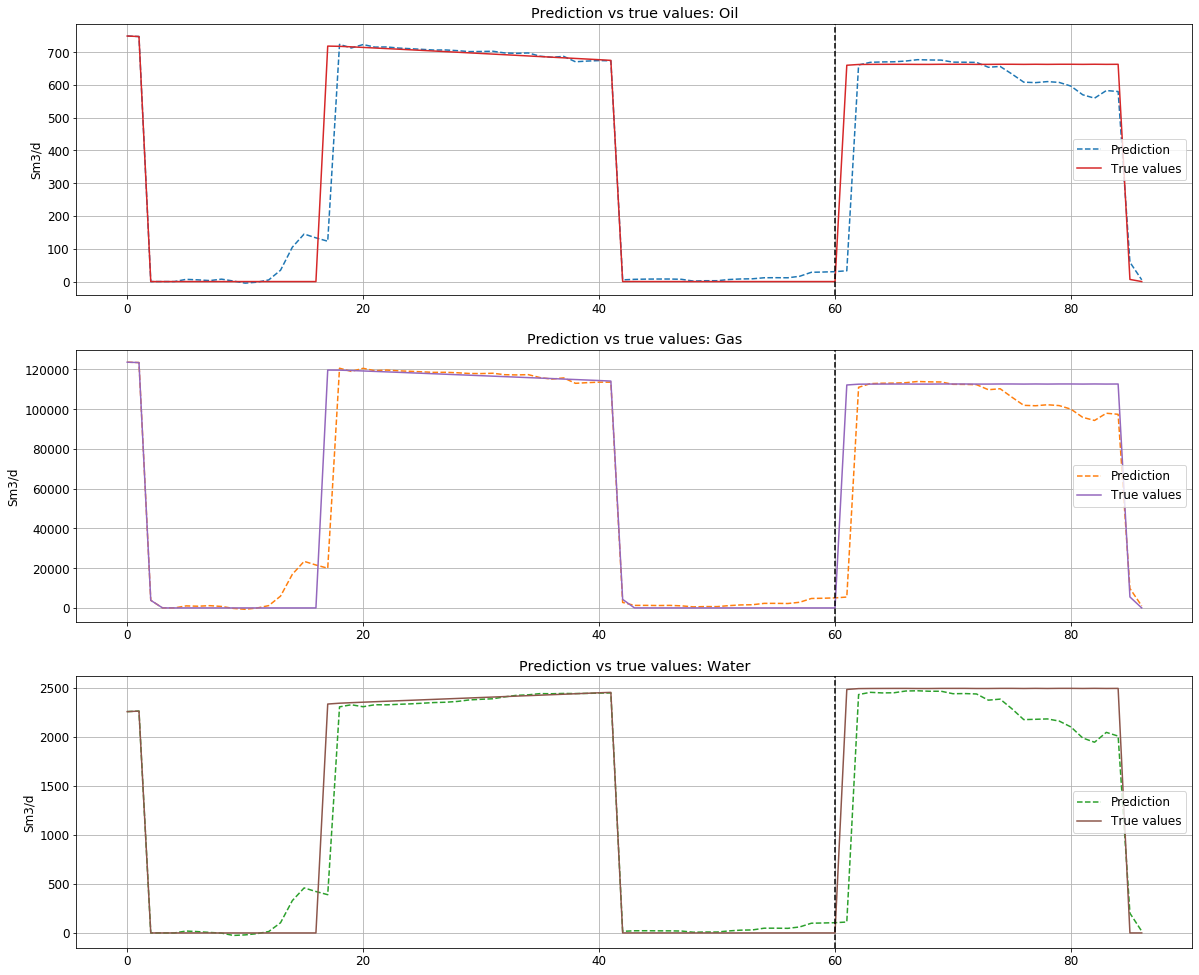

In [45]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped, verbose=0)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [46]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')

## MLP 
(MAE, 3 layers, 100 neurons, do=0.2, lr=1e-4, epochs=500)

In [29]:
MODEL_NAME = 'MLP-2'
LOSS = 'mae'

In [30]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 500
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 500
    import tensorflow.keras.optimizers
    batch_x = 17
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=50, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, max_depth=5, reg_alpha=1))

In [31]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [32]:
def scheduler(epoch, lr):
    if epoch < 25:
        return 1e-3
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 1e-5
    else:
        return 1e-6

callback = LearningRateScheduler(scheduler)

In [33]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
    shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
    model_inf = model.fit(X_train_shuffle[:shape_train], y_train_shuffle[:shape_train], epochs=n_epochs, verbose=1, validation_data=(X_valid[:shape_test], y_valid[:shape_test]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_reshaped, y)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, callbacks=[callback], batch_size=128, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Train on 19748 samples, validate on 2747 samples
Epoch 1/500
19748/19748 [==============================] - 1s 73us/step - loss: 0.2411 - val_loss: 0.0974
Epoch 2/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.1339 - val_loss: 0.0878
Epoch 3/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.1102 - val_loss: 0.0866
Epoch 4/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0993 - val_loss: 0.0906
Epoch 5/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0930 - val_loss: 0.0959
Epoch 6/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0877 - val_loss: 0.0874
Epoch 7/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0841 - val_loss: 0.0945
Epoch 8/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0812 - val_loss: 0.1027
Epoch 9/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0782 - val_loss: 0.09

19748/19748 [==============================] - 1s 51us/step - loss: 0.0352 - val_loss: 0.0235
Epoch 154/500
19748/19748 [==============================] - 1s 50us/step - loss: 0.0350 - val_loss: 0.0236
Epoch 155/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0350 - val_loss: 0.0234
Epoch 156/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0351 - val_loss: 0.0233
Epoch 157/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0350 - val_loss: 0.0233
Epoch 158/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0350 - val_loss: 0.0237
Epoch 159/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0350 - val_loss: 0.0236
Epoch 160/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0351 - val_loss: 0.0235
Epoch 161/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0351 - val_loss: 0.0235
Epoch 162/500
19748/19748 [===============

Epoch 304/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0344 - val_loss: 0.0238
Epoch 305/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0344 - val_loss: 0.0241
Epoch 306/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0344 - val_loss: 0.0241
Epoch 307/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0344 - val_loss: 0.0242
Epoch 308/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0343 - val_loss: 0.0239
Epoch 309/500
19748/19748 [==============================] - 1s 52us/step - loss: 0.0344 - val_loss: 0.0249
Epoch 310/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0345 - val_loss: 0.0244
Epoch 311/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0344 - val_loss: 0.0238
Epoch 312/500
19748/19748 [==============================] - 1s 51us/step - loss: 0.0344 - val_loss: 0.0241
Epoch 313/500
19748/19748 [=

Epoch 380/500
19748/19748 [==============================] - 1s 61us/step - loss: 0.0342 - val_loss: 0.0245
Epoch 381/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0342 - val_loss: 0.0239
Epoch 382/500
19748/19748 [==============================] - 1s 56us/step - loss: 0.0343 - val_loss: 0.0238
Epoch 383/500
19748/19748 [==============================] - 1s 57us/step - loss: 0.0343 - val_loss: 0.0243
Epoch 384/500
19748/19748 [==============================] - 1s 57us/step - loss: 0.0342 - val_loss: 0.0236
Epoch 385/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0342 - val_loss: 0.0238
Epoch 386/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0342 - val_loss: 0.0238
Epoch 387/500
19748/19748 [==============================] - 1s 58us/step - loss: 0.0342 - val_loss: 0.0243
Epoch 388/500
19748/19748 [==============================] - 1s 56us/step - loss: 0.0342 - val_loss: 0.0245
Epoch 389/500
19748/19748 [=

Epoch 456/500
19748/19748 [==============================] - 1s 54us/step - loss: 0.0340 - val_loss: 0.0247
Epoch 457/500
19748/19748 [==============================] - 1s 54us/step - loss: 0.0341 - val_loss: 0.0245
Epoch 458/500
19748/19748 [==============================] - 1s 54us/step - loss: 0.0340 - val_loss: 0.0243
Epoch 459/500
19748/19748 [==============================] - 1s 53us/step - loss: 0.0341 - val_loss: 0.0244
Epoch 460/500
19748/19748 [==============================] - 1s 54us/step - loss: 0.0341 - val_loss: 0.0244
Epoch 461/500
19748/19748 [==============================] - 1s 57us/step - loss: 0.0340 - val_loss: 0.0244
Epoch 462/500
19748/19748 [==============================] - 1s 59us/step - loss: 0.0340 - val_loss: 0.0245
Epoch 463/500
19748/19748 [==============================] - 1s 53us/step - loss: 0.0341 - val_loss: 0.0243
Epoch 464/500
19748/19748 [==============================] - 1s 56us/step - loss: 0.0341 - val_loss: 0.0244
Epoch 465/500
19748/19748 [=

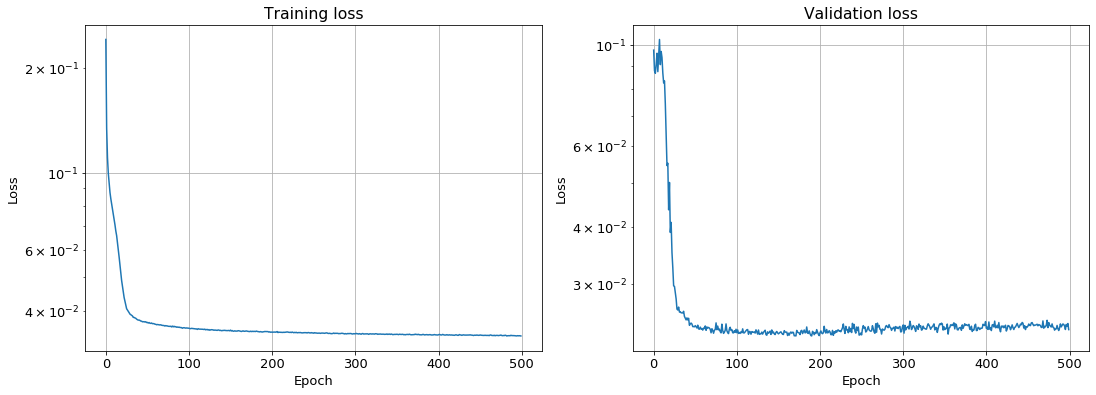

In [34]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

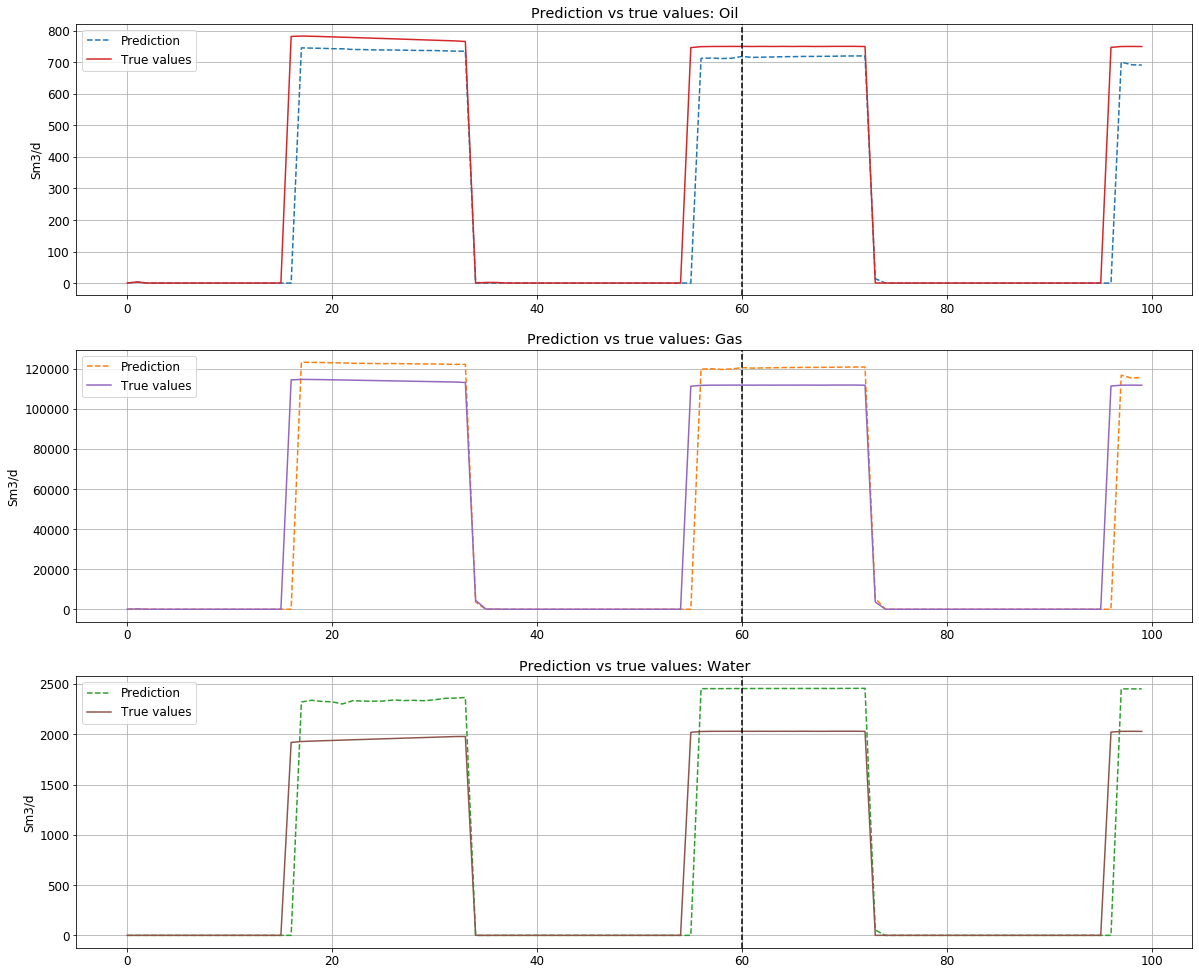

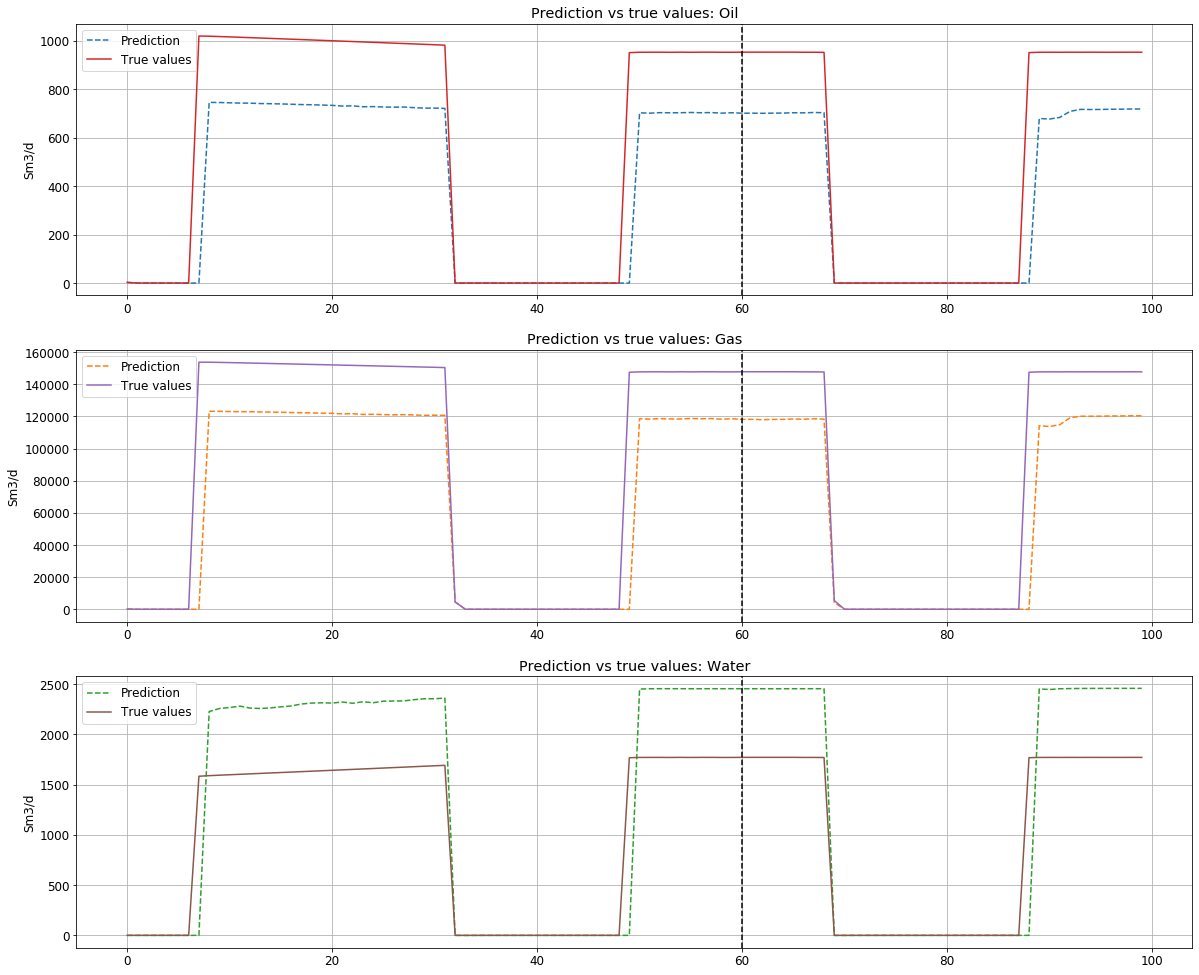

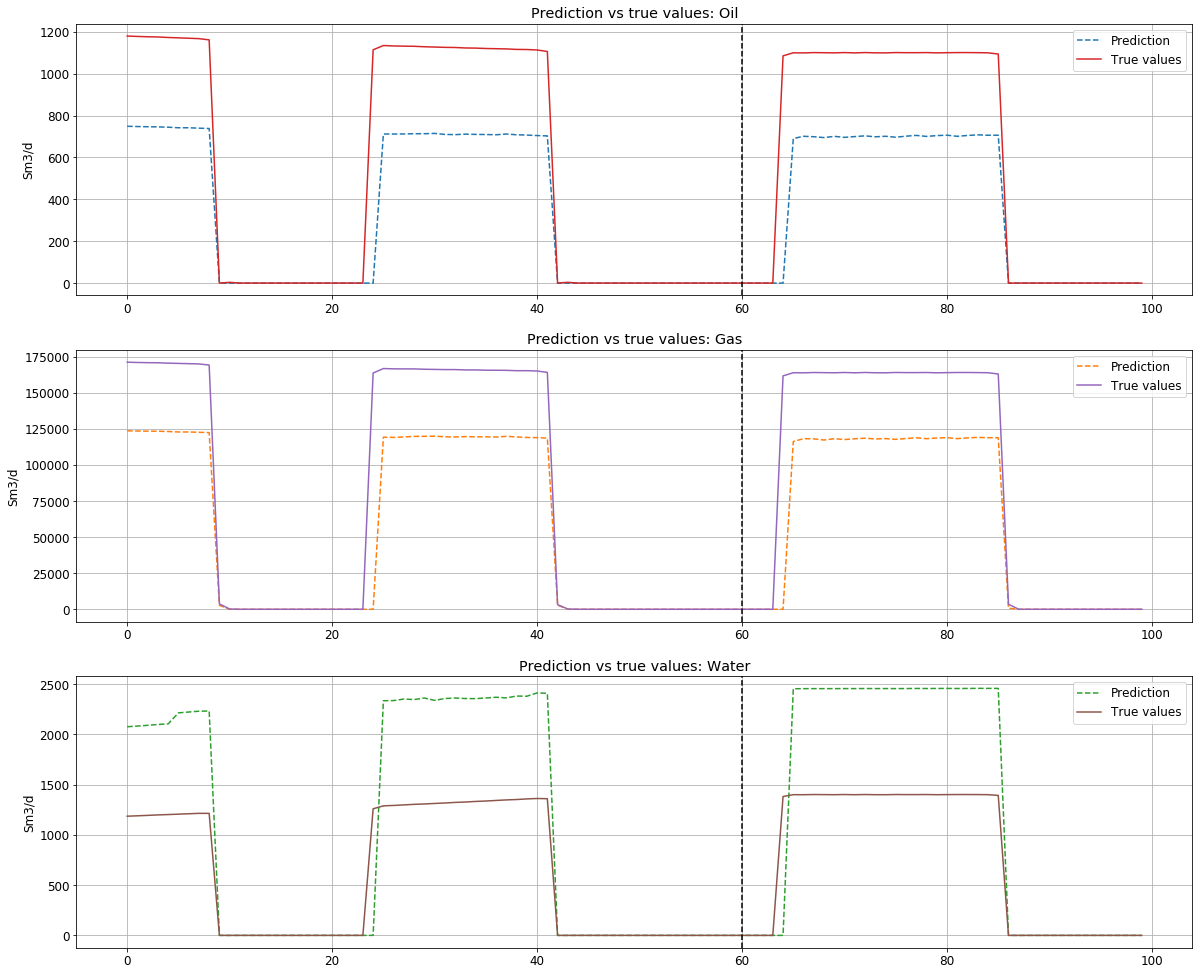

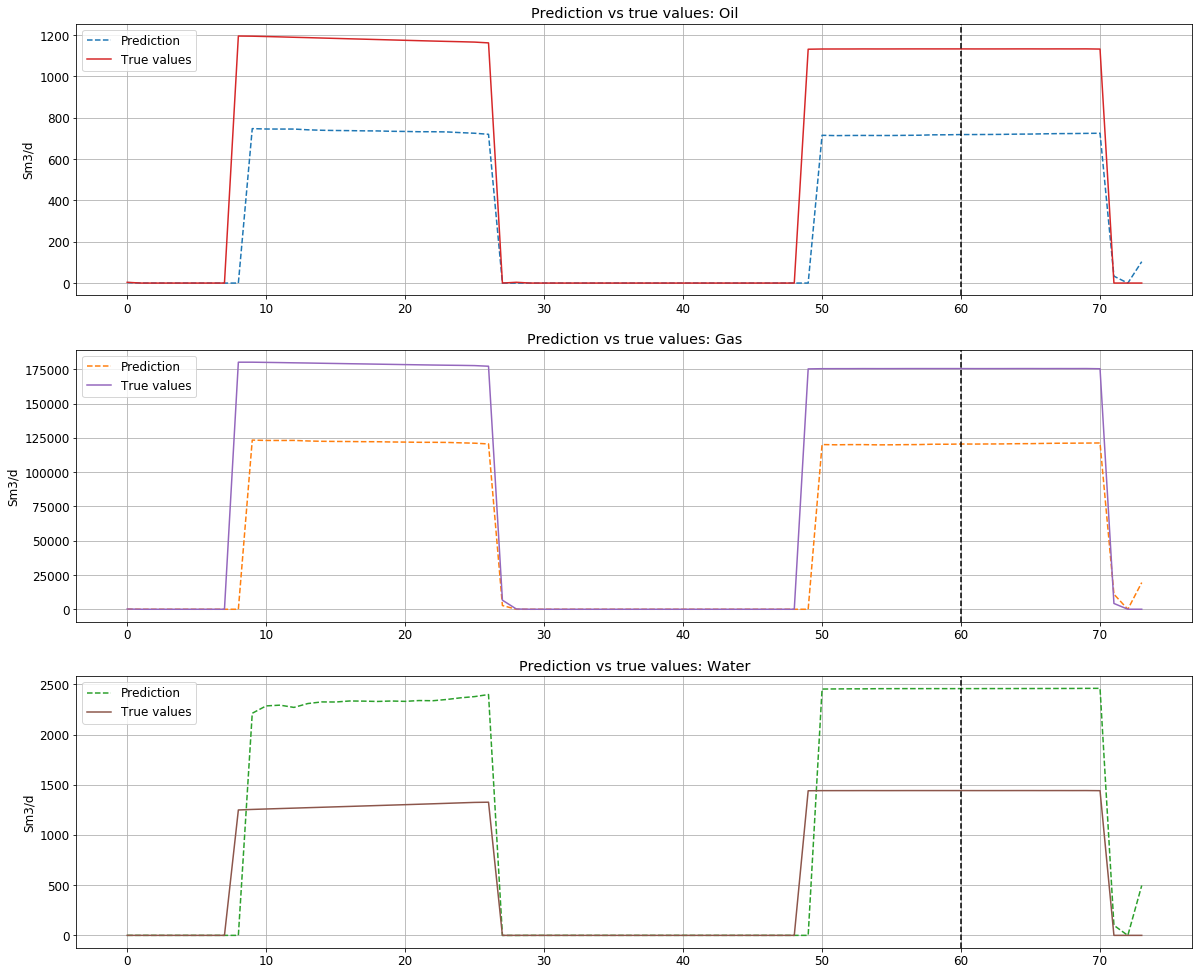

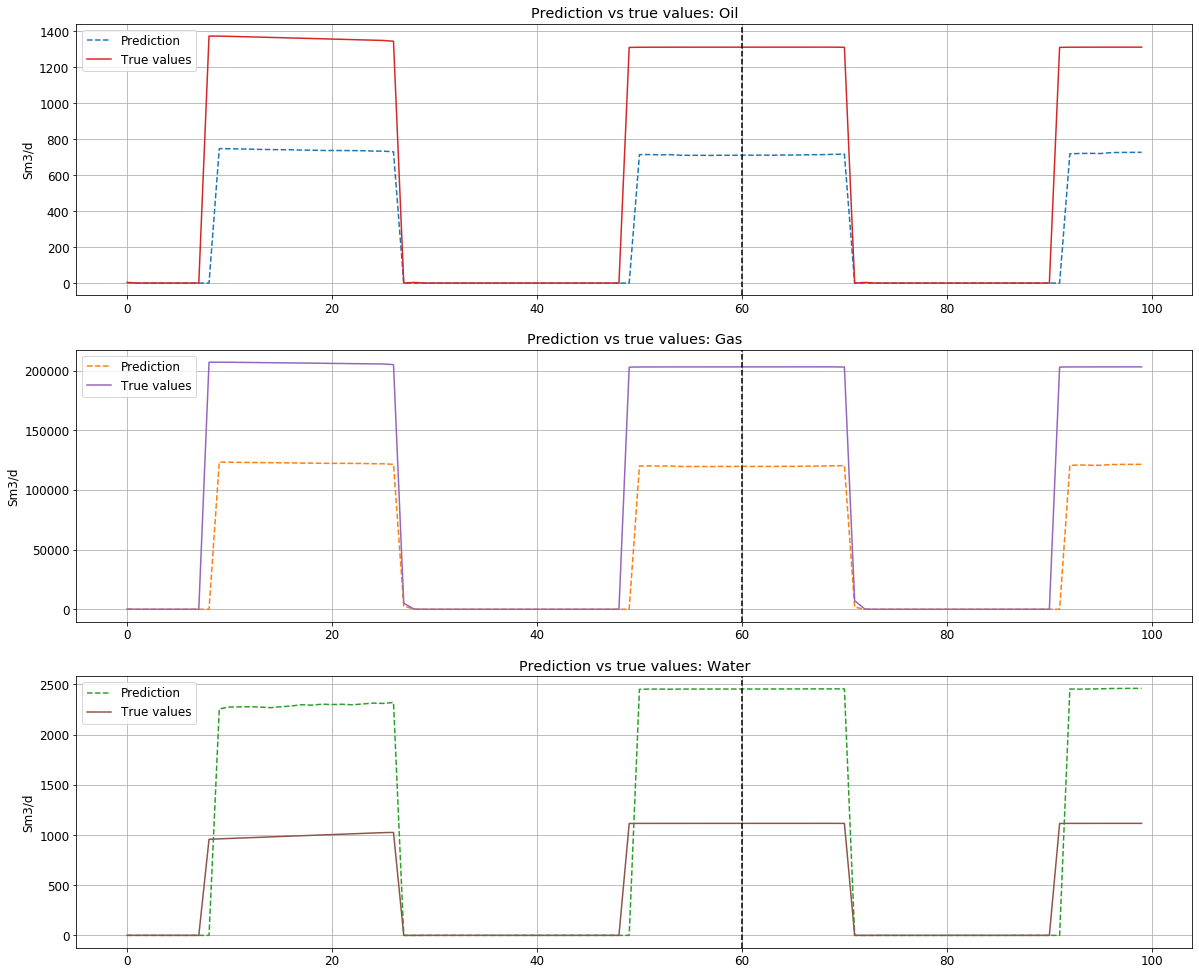

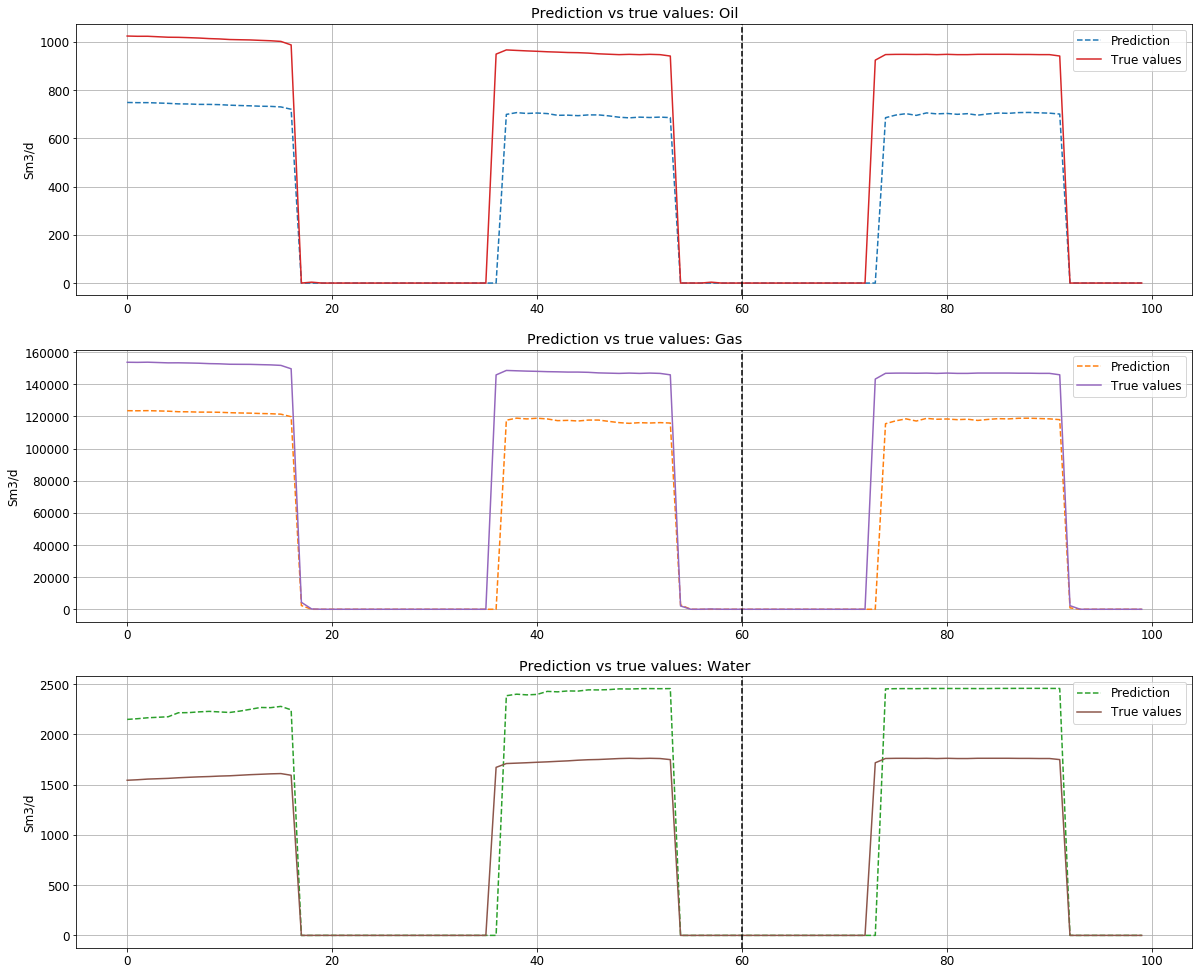

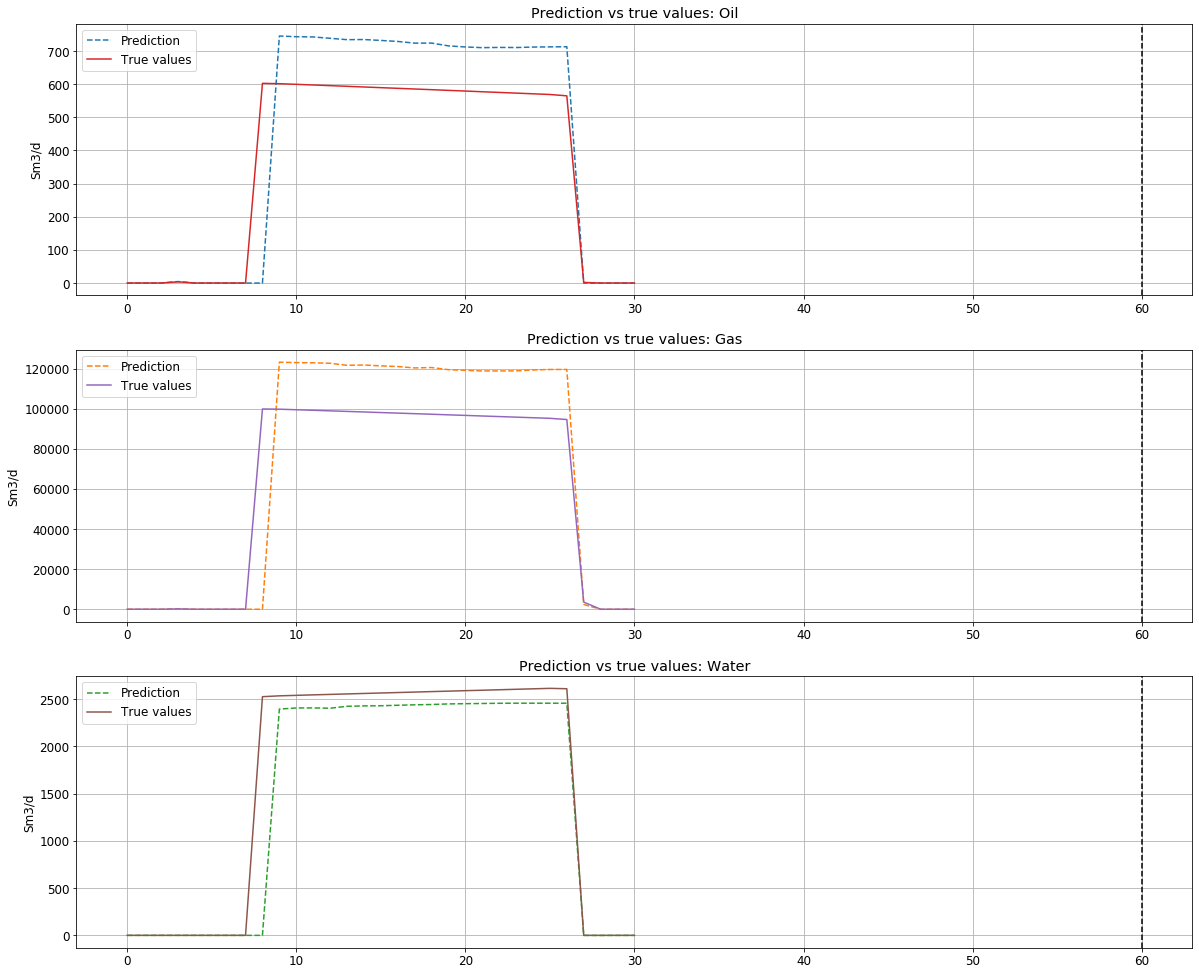

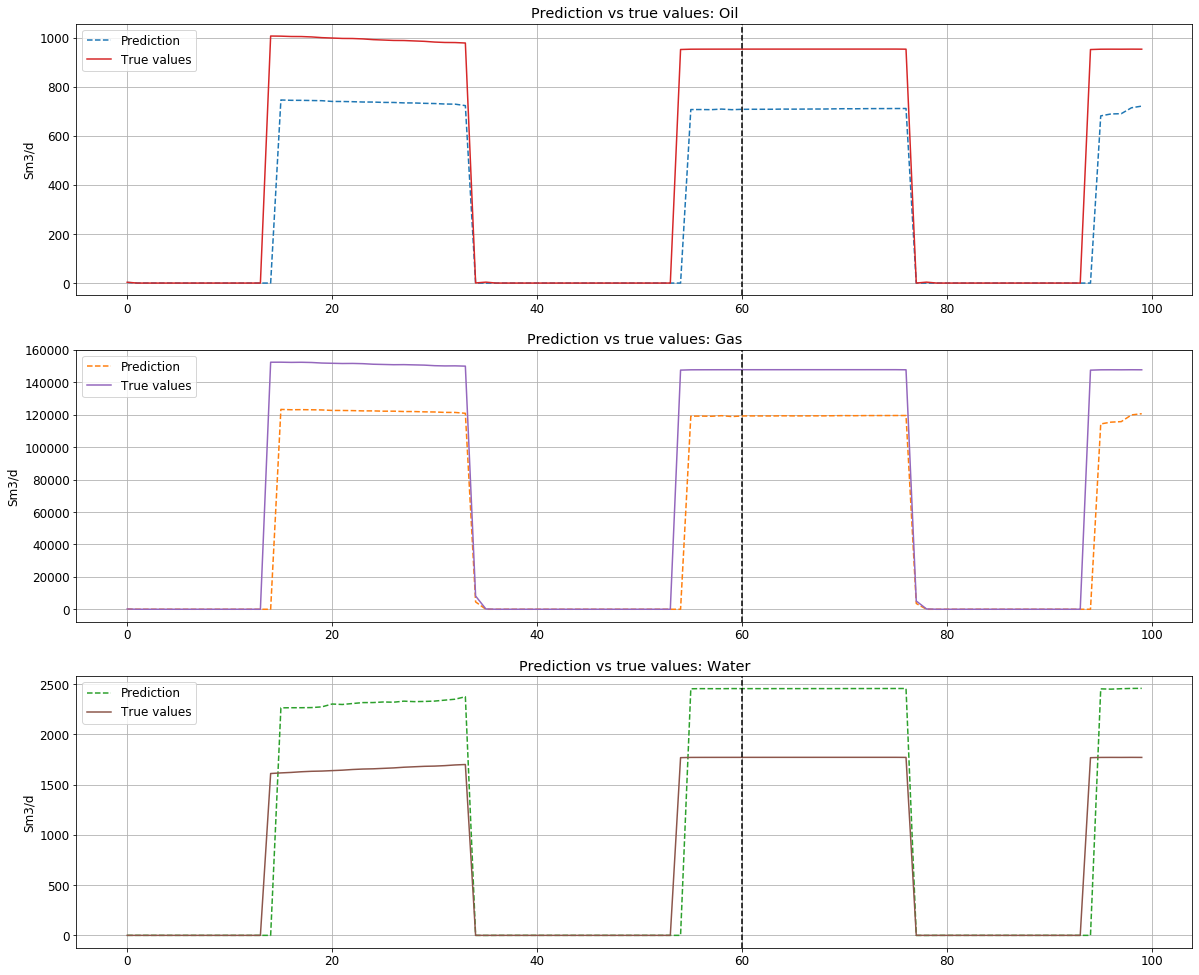

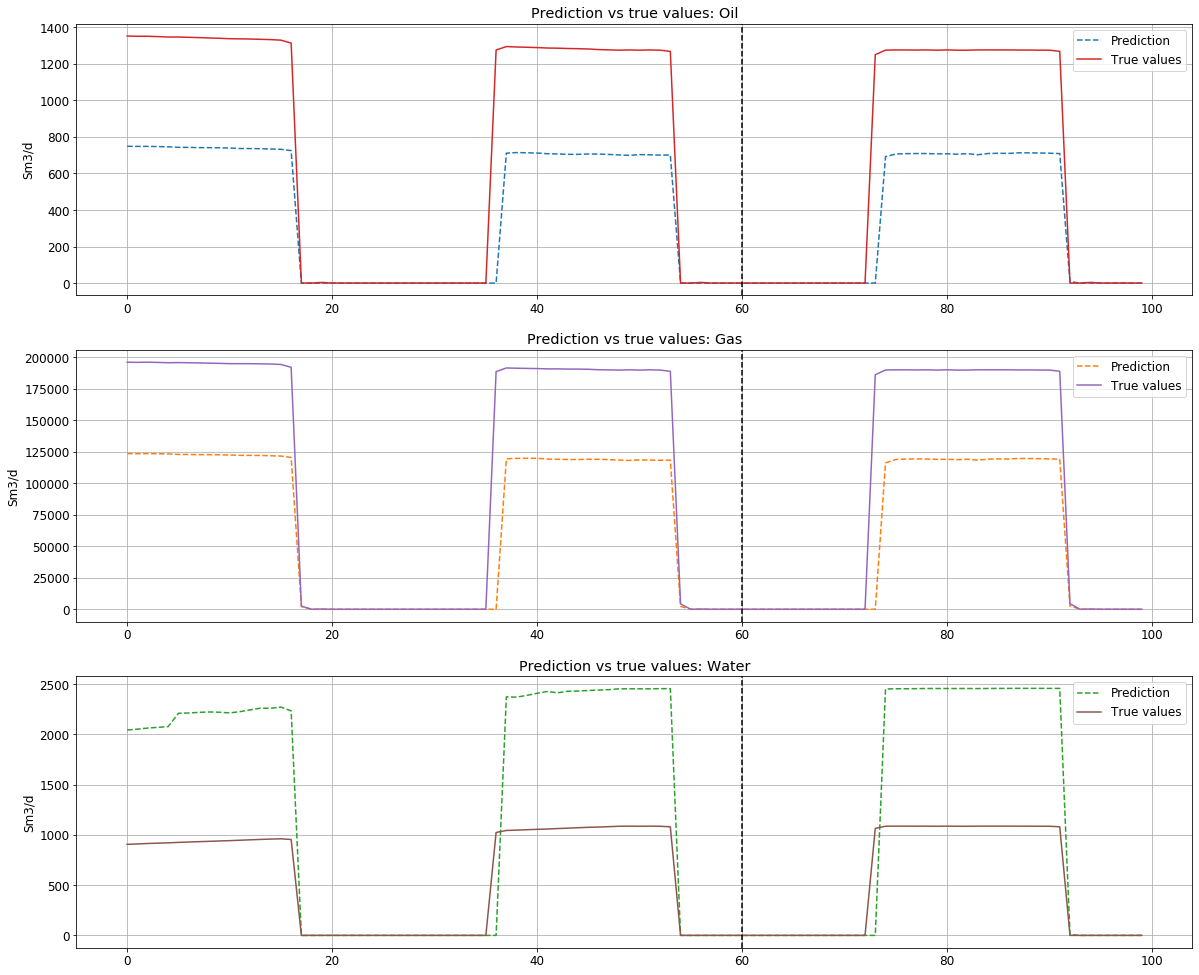

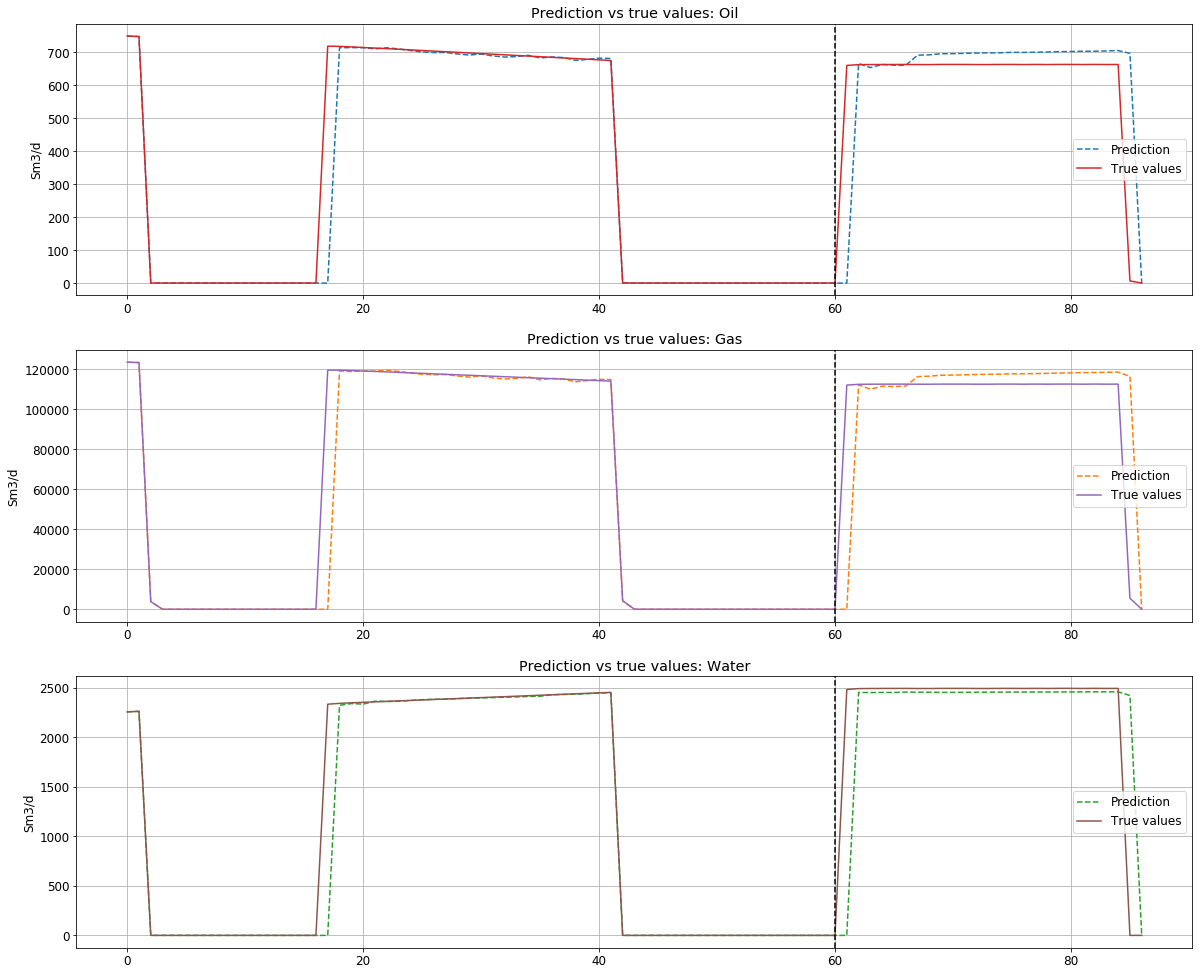

In [35]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped, verbose=0)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [38]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')

## LSTM

In [8]:
MODEL_NAME = 'LSTM-1'
LOSS = 'mae'

In [9]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 300
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 500
    import tensorflow.keras.optimizers
    batch_x = 17
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=50, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, max_depth=5, reg_alpha=1))

In [10]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [11]:
def scheduler(epoch, lr):
    if epoch < 7:
        return 1e-2
    if epoch < 15:
        return 1e-4
    elif epoch < 20:
        return 1e-6
    else:
        return 1e-8
    
callback = LearningRateScheduler(scheduler)

In [12]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
    shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
    model_inf = model.fit(X_train_shuffle[:shape_train], y_train_shuffle[:shape_train], epochs=n_epochs, verbose=1, validation_data=(X_valid[:shape_test], y_valid[:shape_test]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_reshaped, y)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, callbacks=[callback], batch_size=128, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Train on 19748 samples, validate on 2747 samples
Epoch 1/40
19748/19748 [==============================] - 3s 139us/step - loss: 0.1055 - val_loss: 0.0574
Epoch 2/40
19748/19748 [==============================] - 2s 103us/step - loss: 0.0624 - val_loss: 0.0502
Epoch 3/40
19748/19748 [==============================] - 2s 106us/step - loss: 0.0606 - val_loss: 0.0464
Epoch 4/40
19748/19748 [==============================] - 2s 107us/step - loss: 0.0587 - val_loss: 0.0424
Epoch 5/40
19748/19748 [==============================] - 2s 107us/step - loss: 0.0582 - val_loss: 0.0431
Epoch 6/40
19748/19748 [==============================] - 2s 106us/step - loss: 0.0575 - val_loss: 0.0428
Epoch 7/40
19748/19748 [==============================] - 2s 109us/step - loss: 0.0557 - val_loss: 0.0431
Epoch 8/40
19748/19748 [==============================] - 2s 108us/step - loss: 0.0537 - val_loss: 0.0397
Epoch 9/40
19748/19748 [==============================] - 2s 110us/step - loss: 0.0531 - val_loss: 0.03

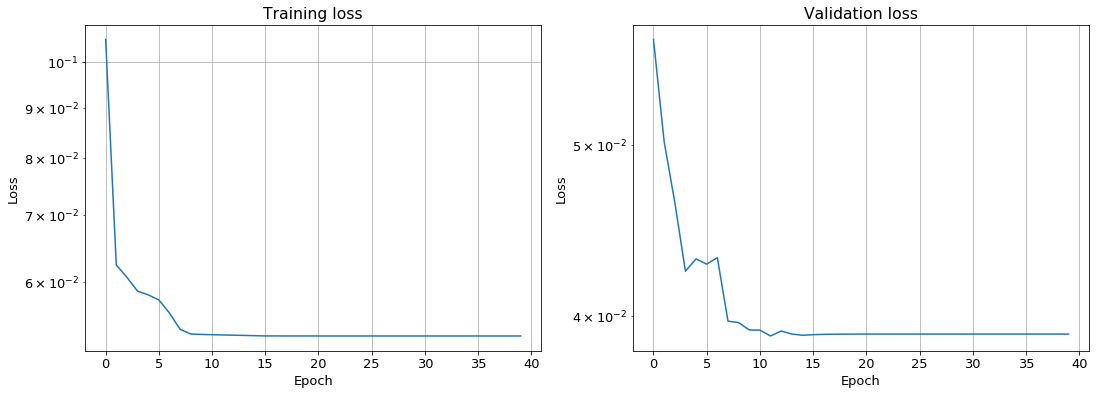

In [13]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

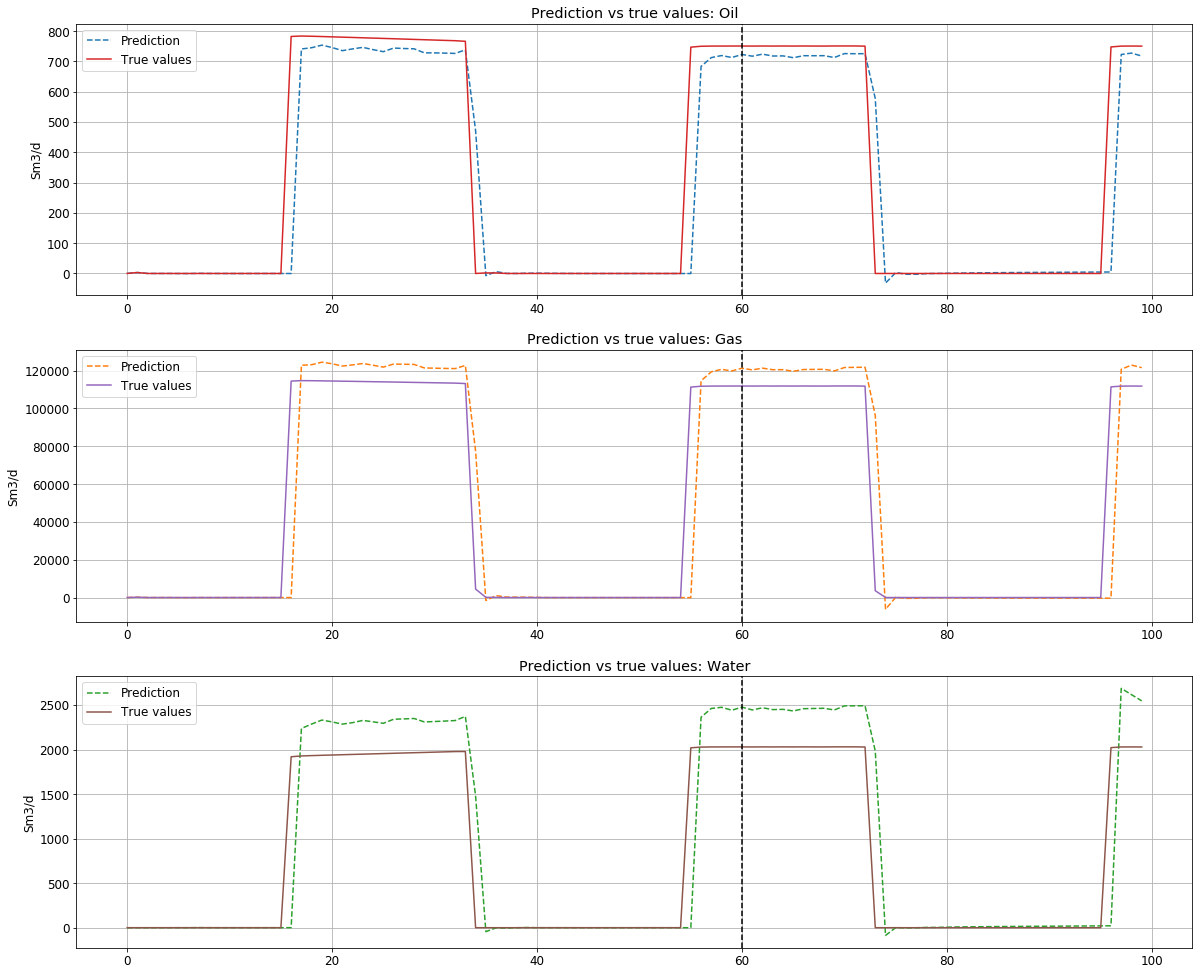

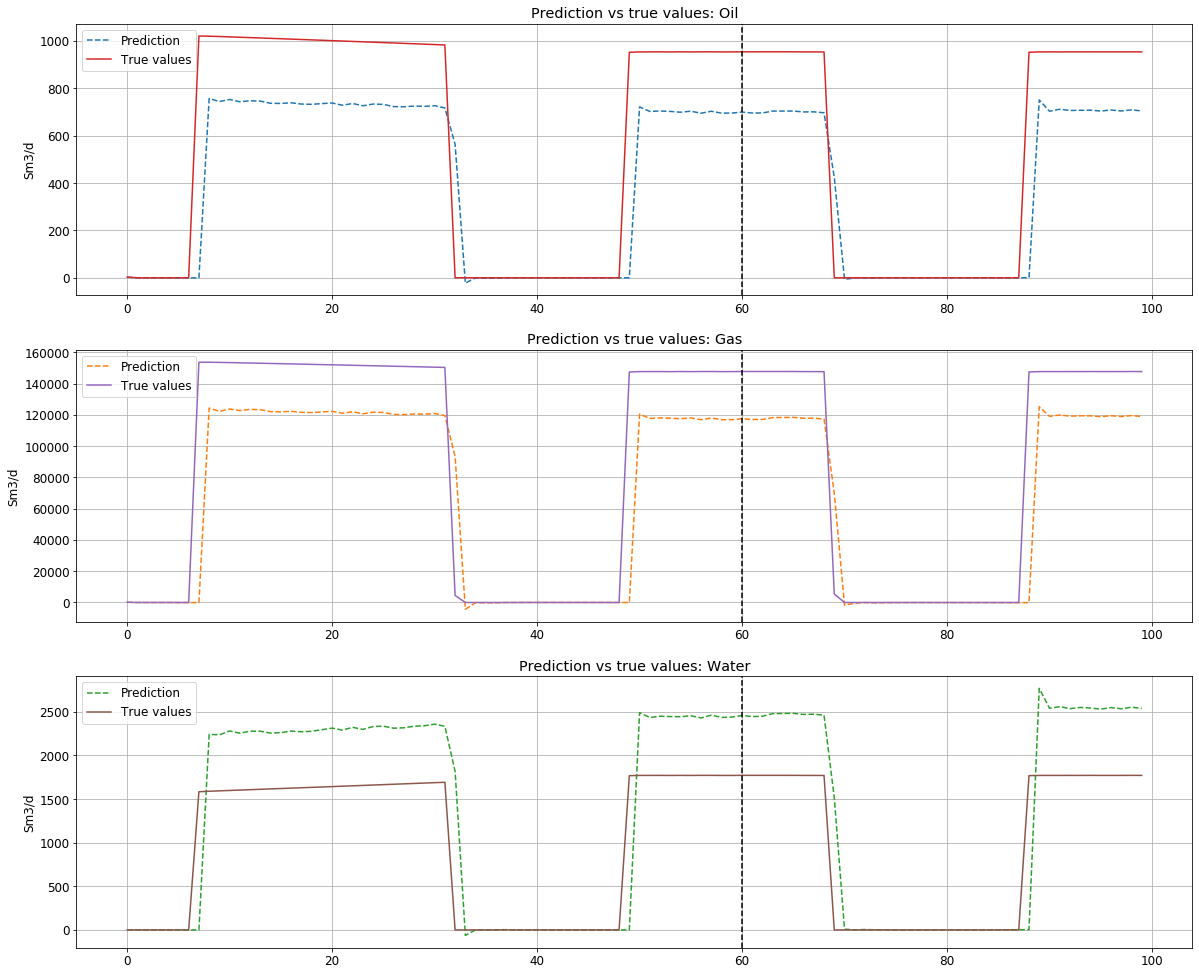

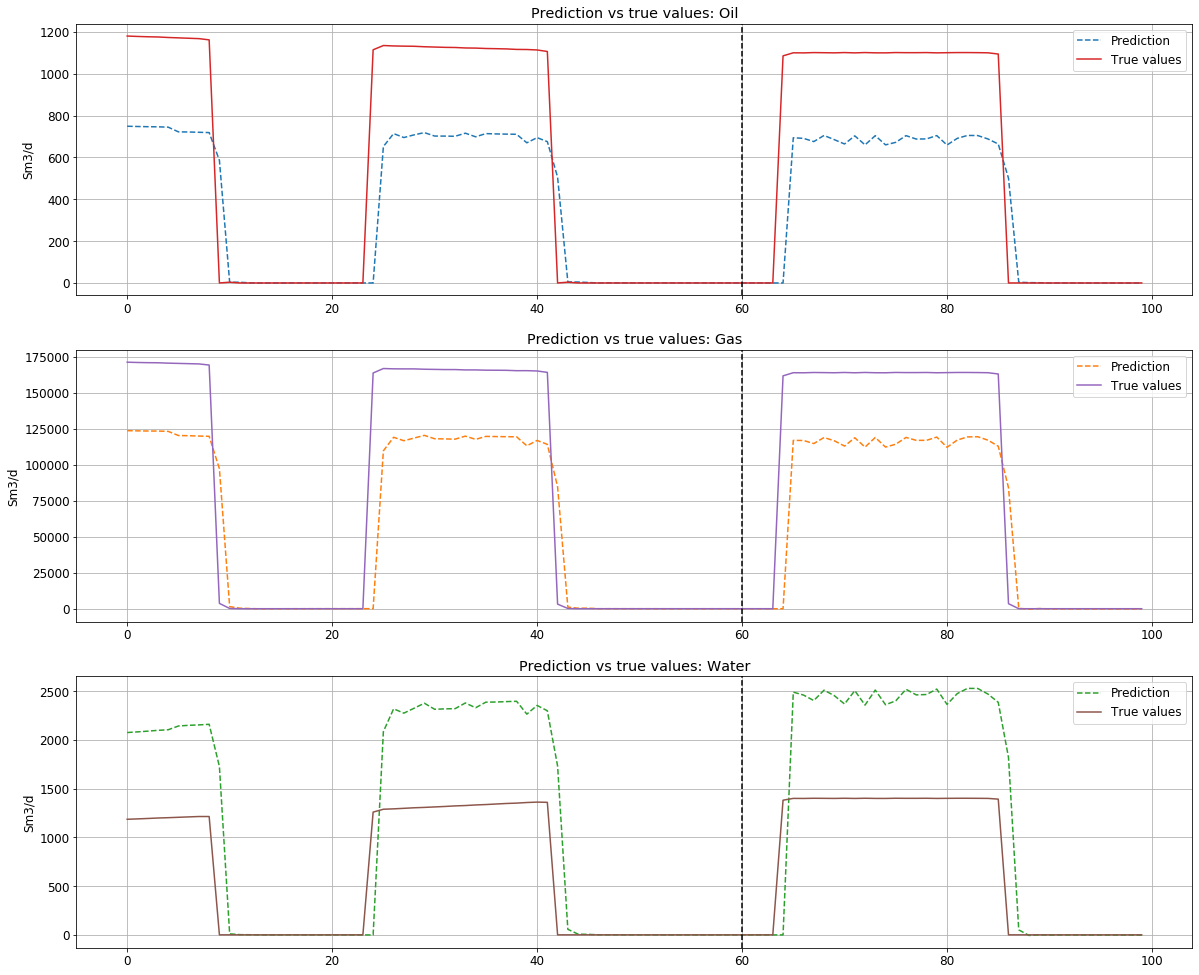

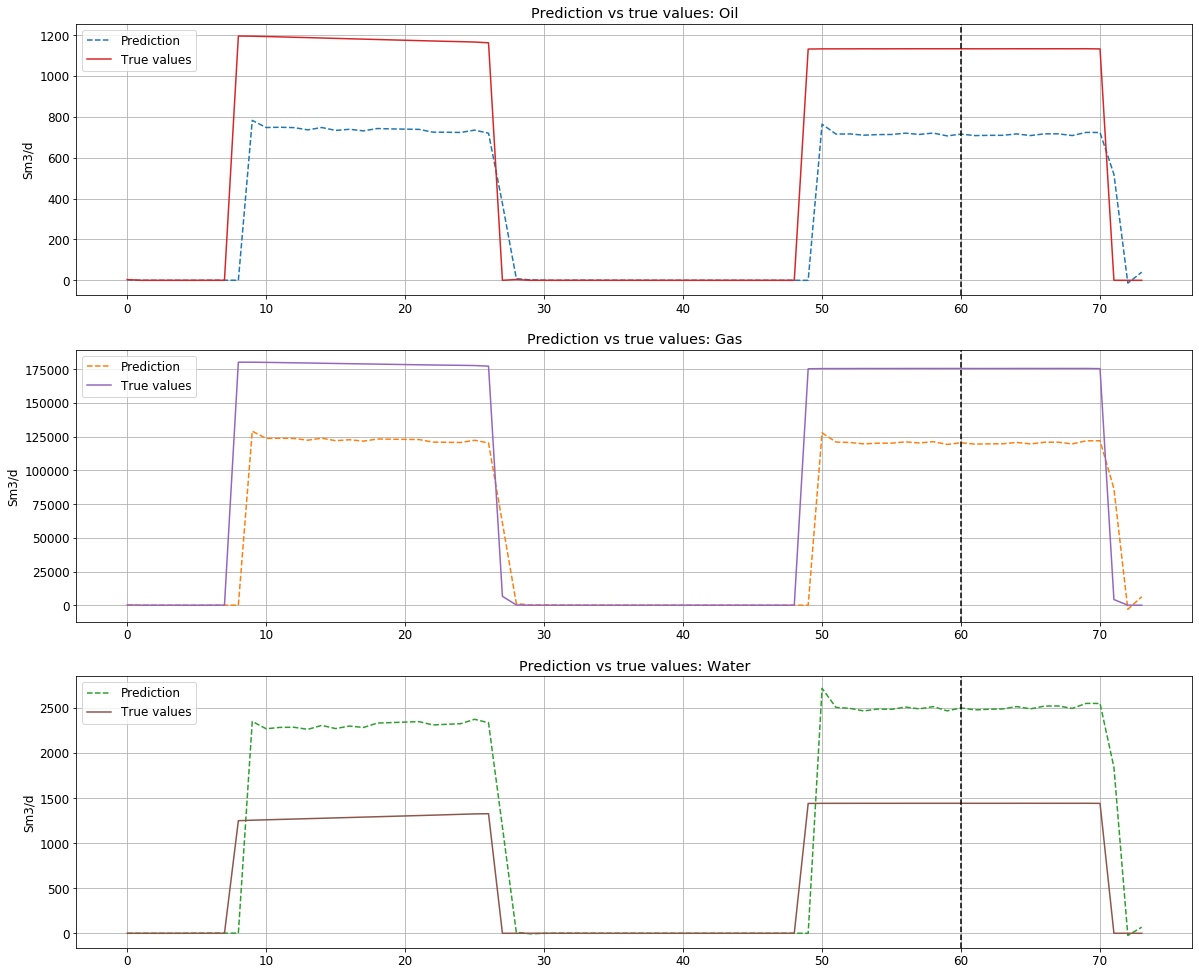

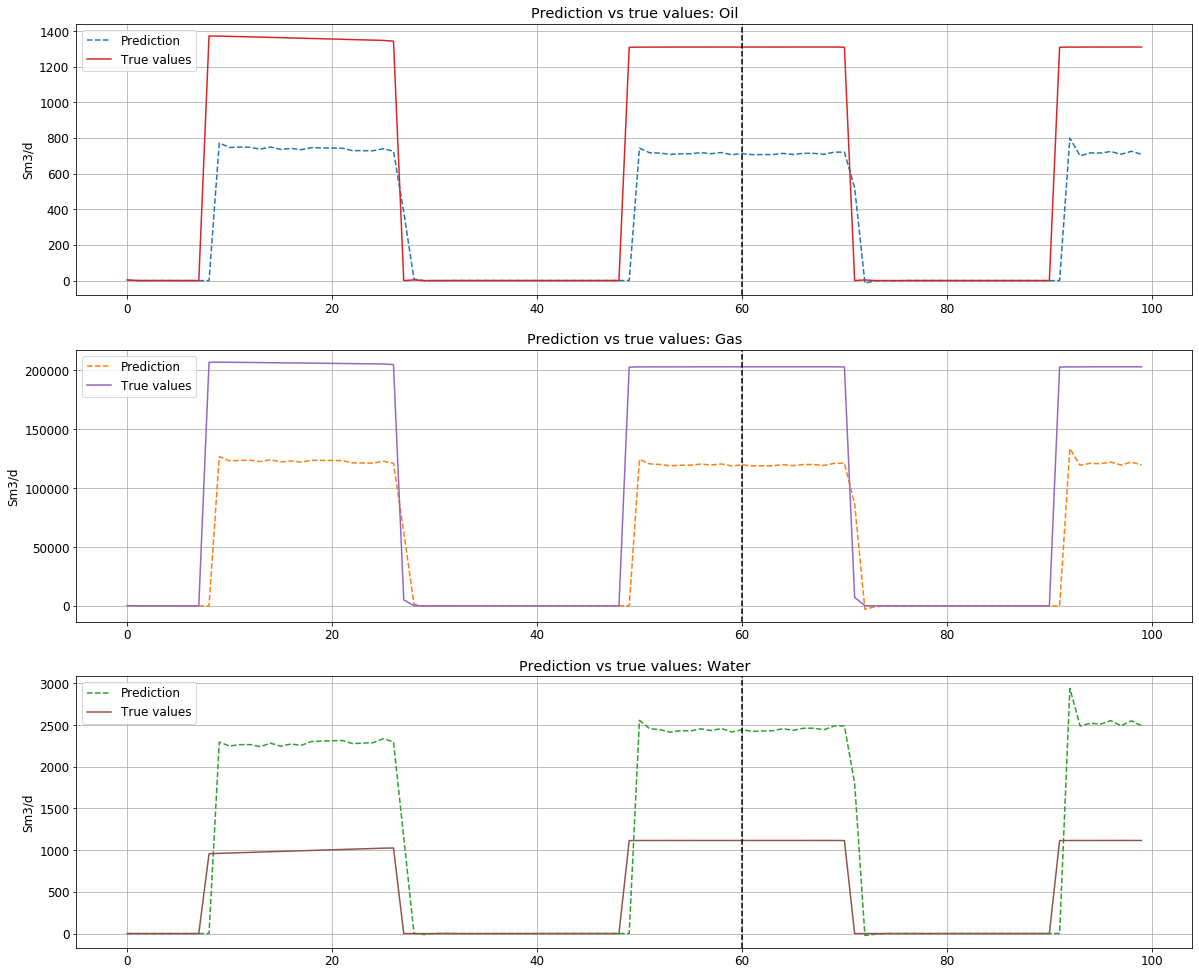

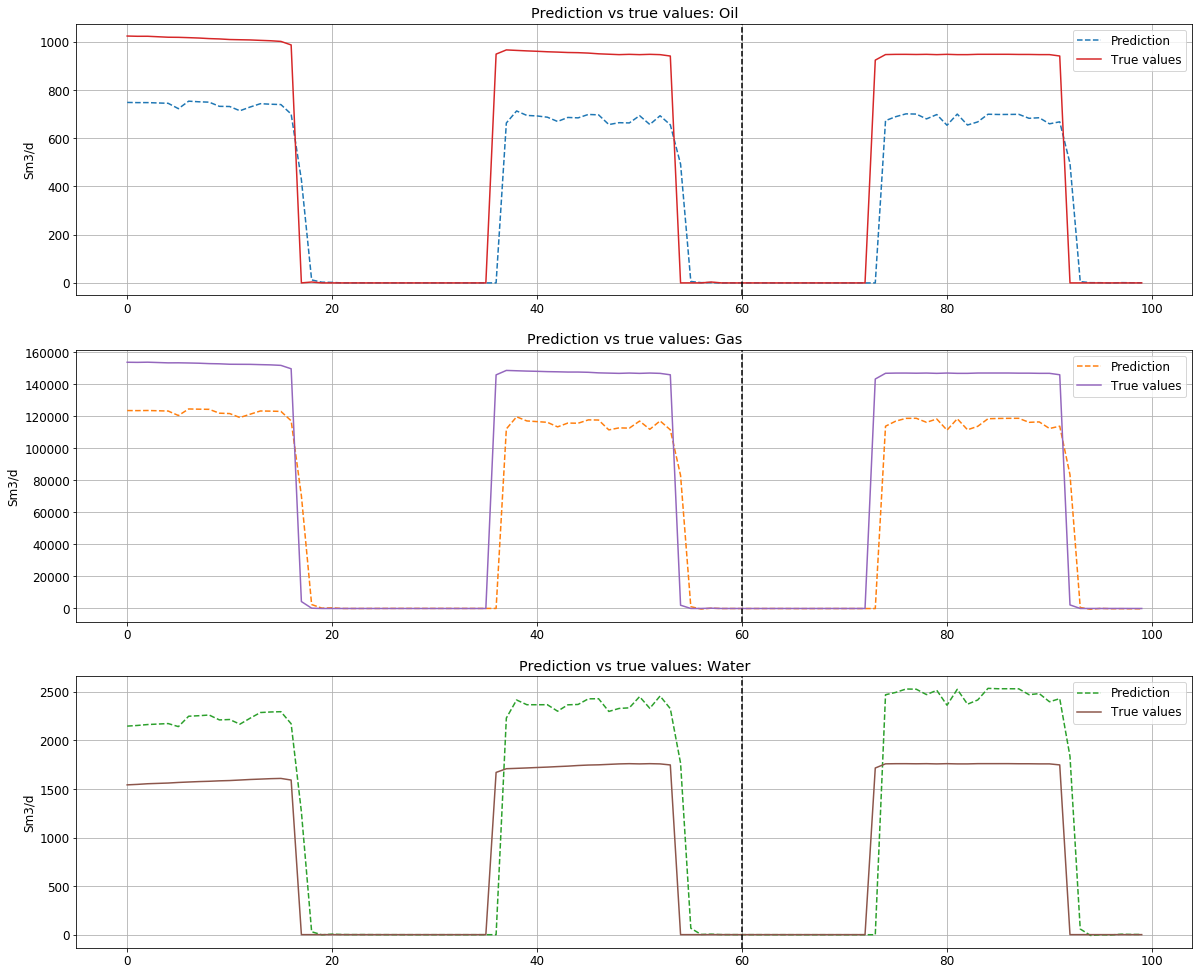

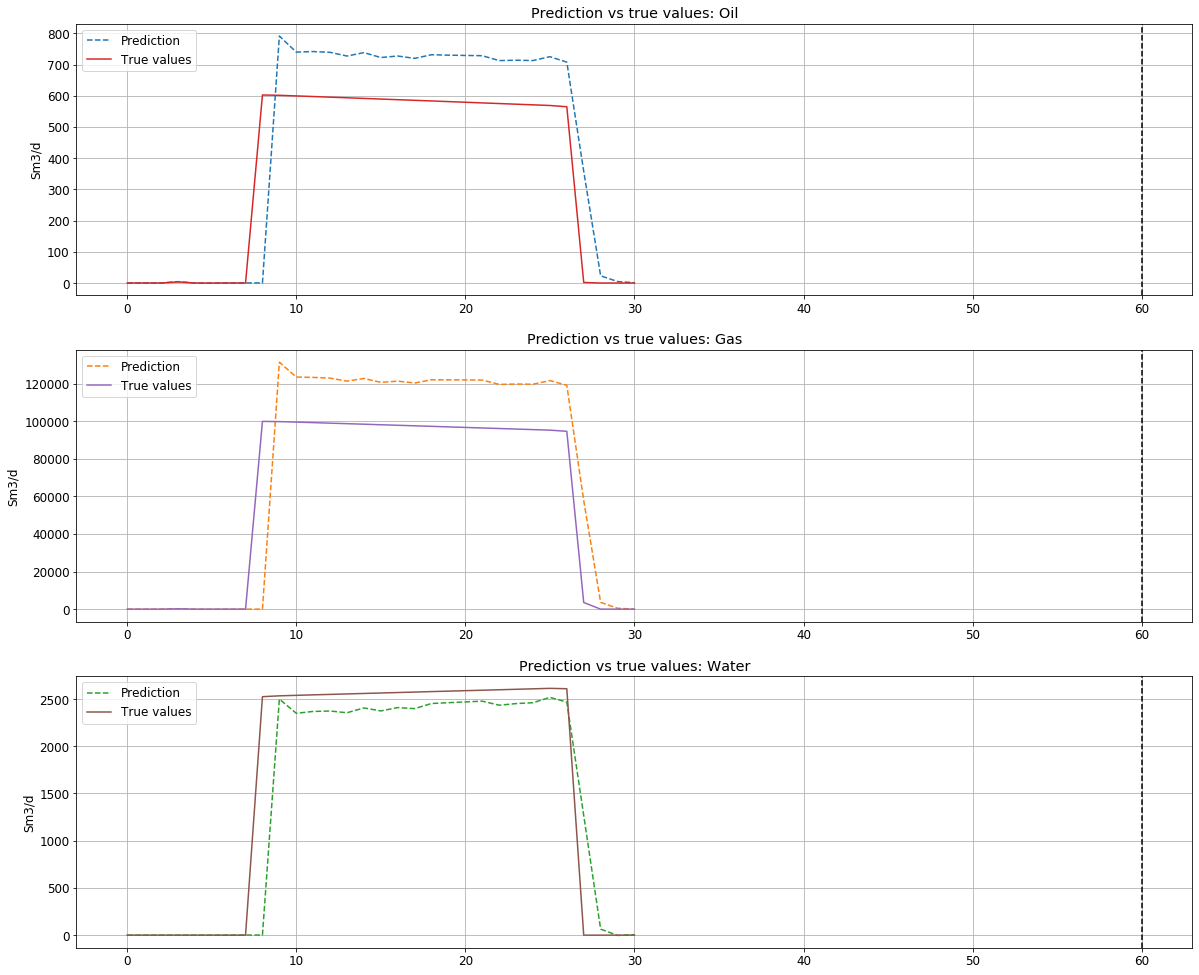

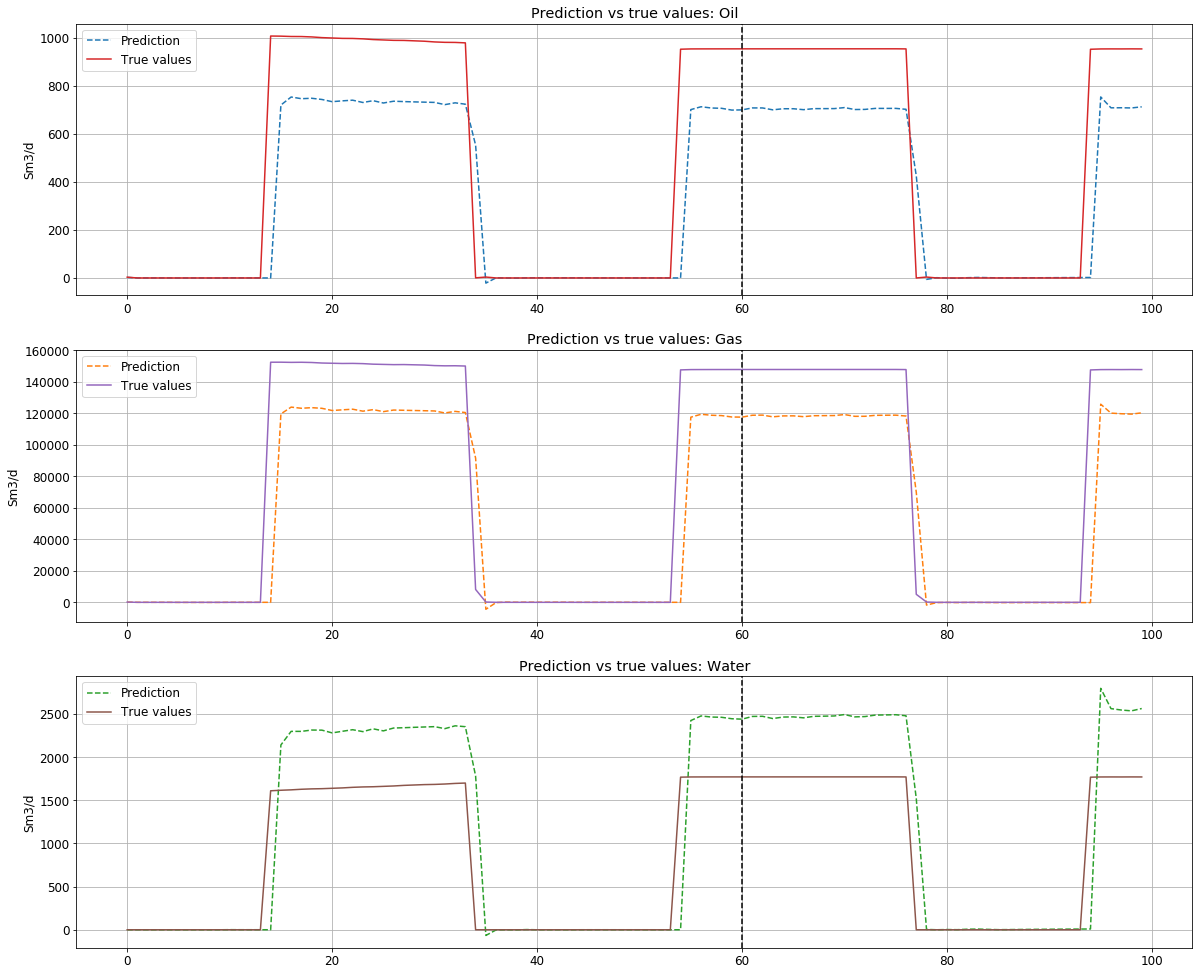

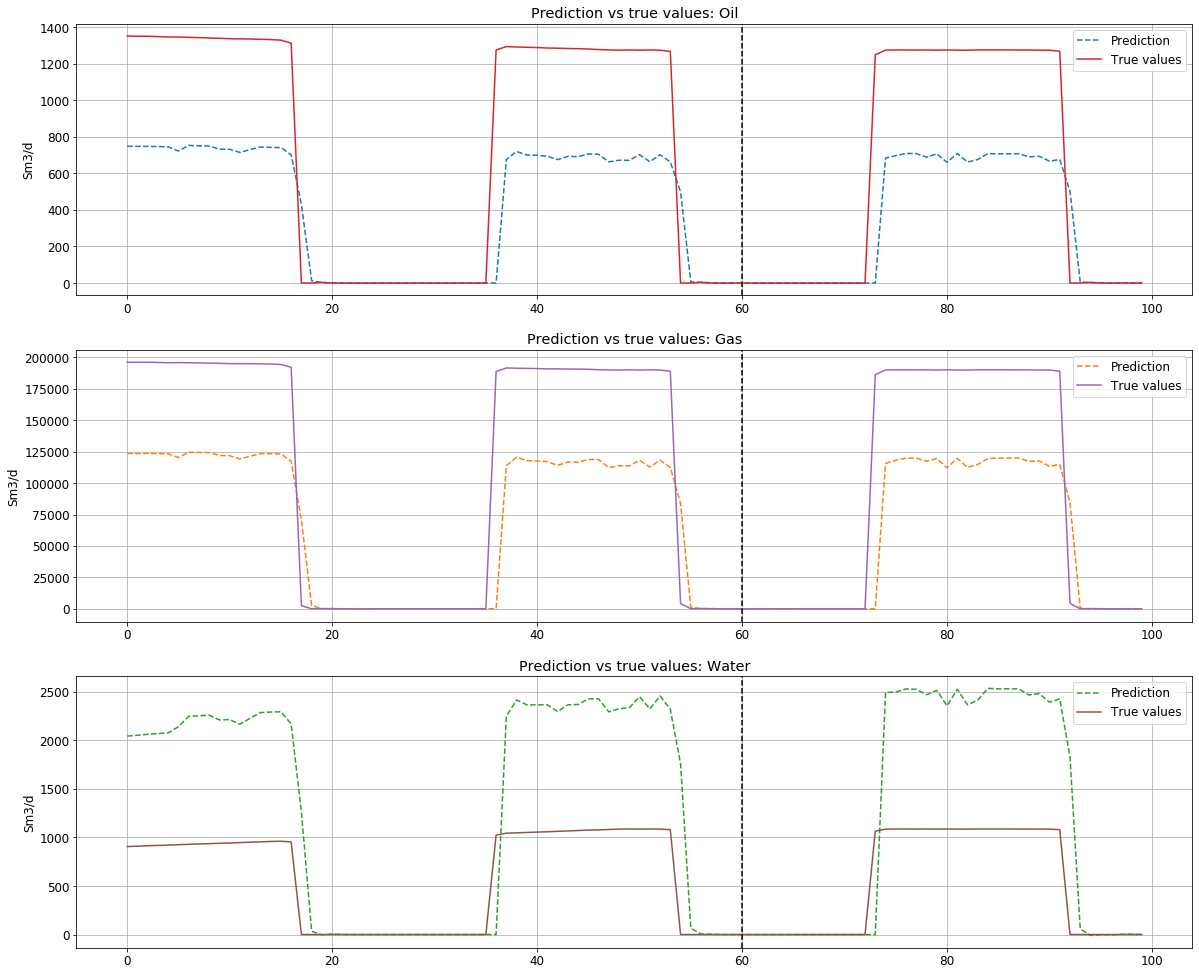

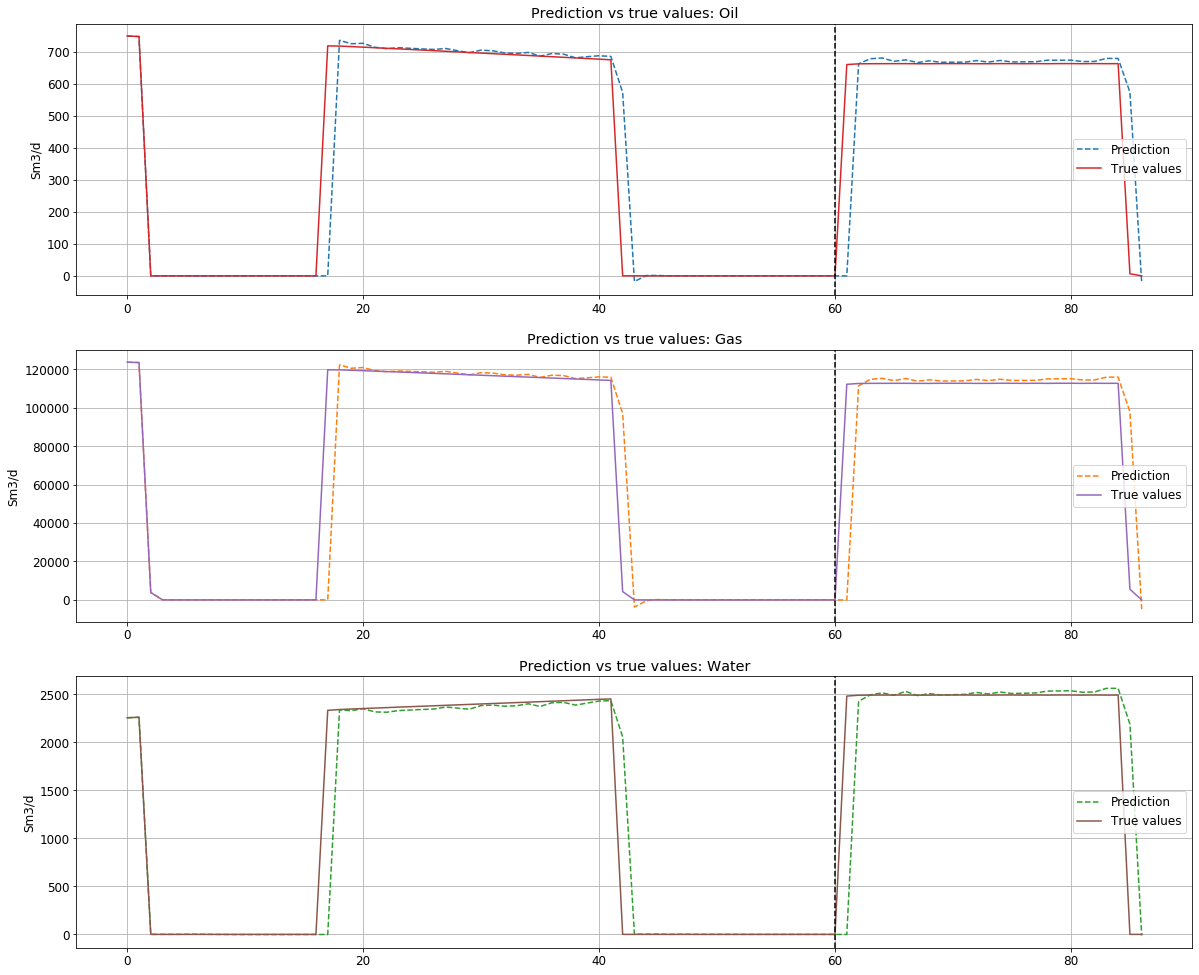

In [14]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped, verbose=0)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [15]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')

## TCN

In [57]:
MODEL_NAME = 'TCN-1'
LOSS = 'mae'

In [58]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [66]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 300
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 300
    import tensorflow.keras.optimizers
    batch_x = 128
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=10, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=100, max_depth=5, reg_alpha=1))

In [67]:
def scheduler(epoch, lr):
    if epoch < 7:
        return 1e-2
    if epoch < 15:
        return 1e-4
    elif epoch < 20:
        return 1e-6
    else:
        return 1e-8
    
callback = LearningRateScheduler(scheduler)

In [68]:
X_train_shuffle.shape, X_valid.shape
shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
print (shape_train, shape_test)

22912 1280


In [69]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
    shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
    model_inf = model.fit(X_train_shuffle[:shape_train], y_train_shuffle[:shape_train], epochs=n_epochs, verbose=1, validation_data=(X_valid[:shape_test], y_valid[:shape_test]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_train_shuffle, y_train_shuffle)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

Train on 22912 samples, validate on 1280 samples
Epoch 1/300
22912/22912 [==============================] - 6s 259us/sample - loss: 1.5544 - val_loss: 0.6022
Epoch 2/300
22912/22912 [==============================] - 4s 160us/sample - loss: 0.6798 - val_loss: 0.2933
Epoch 3/300
22912/22912 [==============================] - 4s 180us/sample - loss: 0.4820 - val_loss: 0.2068
Epoch 4/300
22912/22912 [==============================] - 3s 129us/sample - loss: 0.3911 - val_loss: 0.1733
Epoch 5/300
22912/22912 [==============================] - 3s 140us/sample - loss: 0.3310 - val_loss: 0.1580
Epoch 6/300
22912/22912 [==============================] - 5s 207us/sample - loss: 0.2897 - val_loss: 0.1508
Epoch 7/300
22912/22912 [==============================] - 4s 158us/sample - loss: 0.2561 - val_loss: 0.1422
Epoch 8/300
22912/22912 [==============================] - 4s 165us/sample - loss: 0.2295 - val_loss: 0.1359
Epoch 9/300
22912/22912 [==============================] - 4s 162us/sample - lo

22912/22912 [==============================] - 4s 184us/sample - loss: 0.0384 - val_loss: 0.0322
Epoch 76/300
22912/22912 [==============================] - 5s 213us/sample - loss: 0.0383 - val_loss: 0.0323
Epoch 77/300
22912/22912 [==============================] - 3s 121us/sample - loss: 0.0377 - val_loss: 0.0323
Epoch 78/300
22912/22912 [==============================] - 3s 120us/sample - loss: 0.0374 - val_loss: 0.0319
Epoch 79/300
22912/22912 [==============================] - 4s 174us/sample - loss: 0.0375 - val_loss: 0.0326
Epoch 80/300
22912/22912 [==============================] - 5s 199us/sample - loss: 0.0369 - val_loss: 0.0323
Epoch 81/300
22912/22912 [==============================] - 4s 172us/sample - loss: 0.0370 - val_loss: 0.0316
Epoch 82/300
22912/22912 [==============================] - 5s 204us/sample - loss: 0.0368 - val_loss: 0.0321
Epoch 83/300
22912/22912 [==============================] - 5s 209us/sample - loss: 0.0366 - val_loss: 0.0315
Epoch 84/300
22912/2291

22912/22912 [==============================] - 4s 175us/sample - loss: 0.0313 - val_loss: 0.0298
Epoch 150/300
22912/22912 [==============================] - 4s 177us/sample - loss: 0.0314 - val_loss: 0.0288
Epoch 151/300
22912/22912 [==============================] - 4s 174us/sample - loss: 0.0318 - val_loss: 0.0289
Epoch 152/300
22912/22912 [==============================] - 4s 175us/sample - loss: 0.0315 - val_loss: 0.0295
Epoch 153/300
22912/22912 [==============================] - 4s 179us/sample - loss: 0.0314 - val_loss: 0.0284
Epoch 154/300
22912/22912 [==============================] - 4s 184us/sample - loss: 0.0312 - val_loss: 0.0290
Epoch 155/300
22912/22912 [==============================] - 5s 198us/sample - loss: 0.0314 - val_loss: 0.0290
Epoch 156/300
22912/22912 [==============================] - ETA: 0s - loss: 0.031 - 4s 180us/sample - loss: 0.0310 - val_loss: 0.0291
Epoch 157/300
22912/22912 [==============================] - 4s 173us/sample - loss: 0.0313 - val_loss

22912/22912 [==============================] - 5s 200us/sample - loss: 0.0295 - val_loss: 0.0283
Epoch 223/300
22912/22912 [==============================] - 4s 159us/sample - loss: 0.0298 - val_loss: 0.0278
Epoch 224/300
22912/22912 [==============================] - 5s 201us/sample - loss: 0.0296 - val_loss: 0.0278
Epoch 225/300
22912/22912 [==============================] - 4s 195us/sample - loss: 0.0298 - val_loss: 0.0276
Epoch 226/300
22912/22912 [==============================] - 5s 202us/sample - loss: 0.0296 - val_loss: 0.0276s
Epoch 227/300
22912/22912 [==============================] - 5s 202us/sample - loss: 0.0295 - val_loss: 0.0277
Epoch 228/300
22912/22912 [==============================] - 4s 195us/sample - loss: 0.0299 - val_loss: 0.0279
Epoch 229/300
22912/22912 [==============================] - 4s 174us/sample - loss: 0.0295 - val_loss: 0.0277
Epoch 230/300
22912/22912 [==============================] - 4s 159us/sample - loss: 0.0294 - val_loss: 0.0278
Epoch 231/300


Epoch 296/300
22912/22912 [==============================] - 2s 104us/sample - loss: 0.0289 - val_loss: 0.0279
Epoch 297/300
22912/22912 [==============================] - 2s 106us/sample - loss: 0.0286 - val_loss: 0.0275
Epoch 298/300
22912/22912 [==============================] - 3s 110us/sample - loss: 0.0289 - val_loss: 0.0272
Epoch 299/300
22912/22912 [==============================] - 2s 107us/sample - loss: 0.0285 - val_loss: 0.0271
Epoch 300/300
22912/22912 [==============================] - 2s 105us/sample - loss: 0.0287 - val_loss: 0.0271


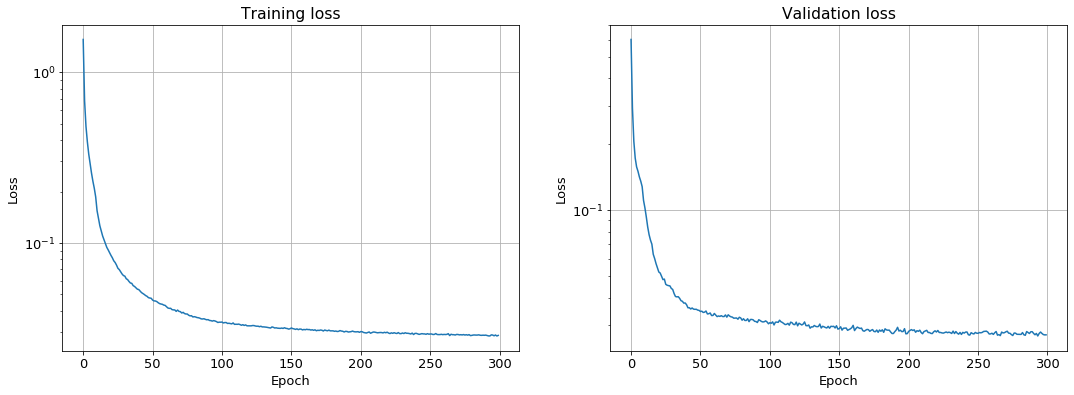

In [70]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

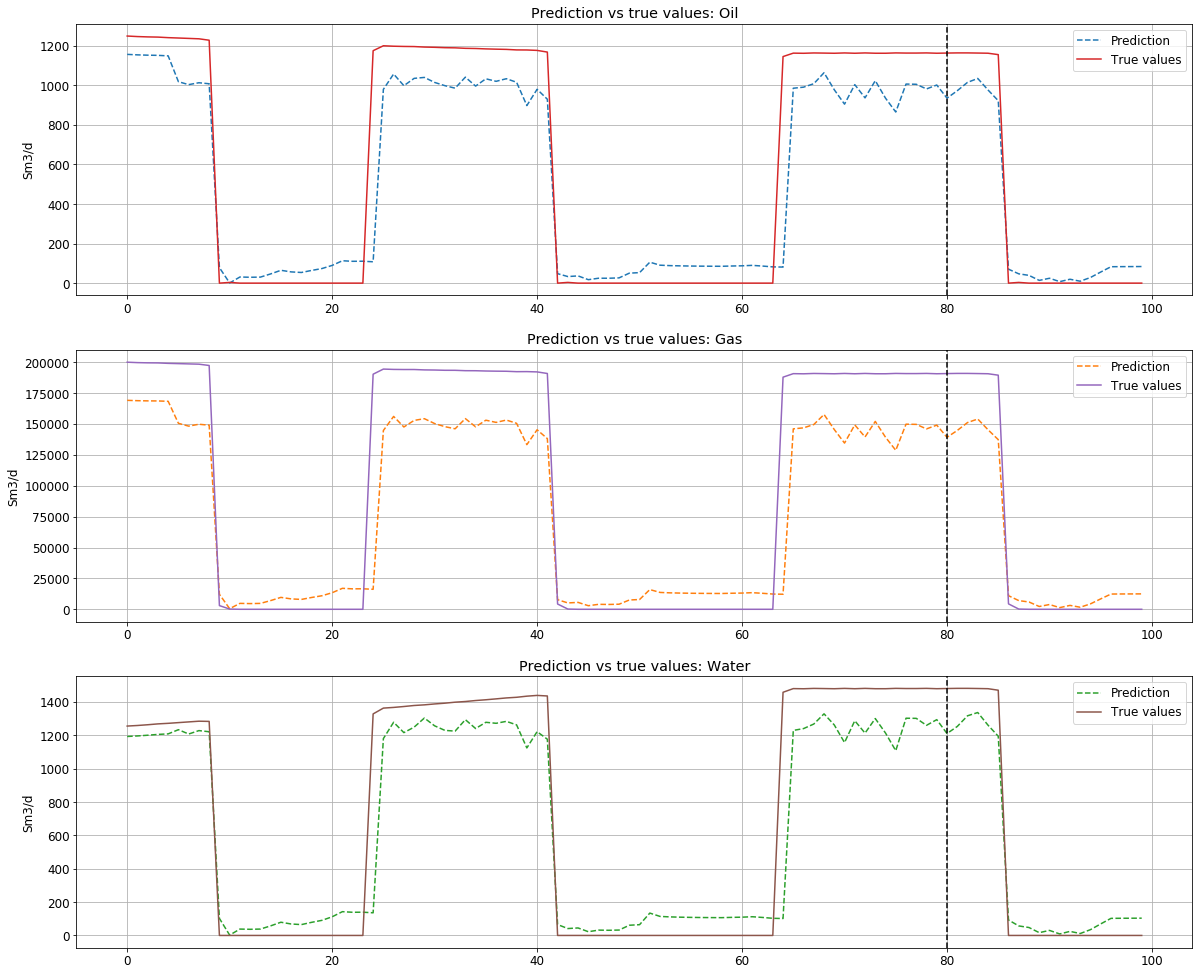

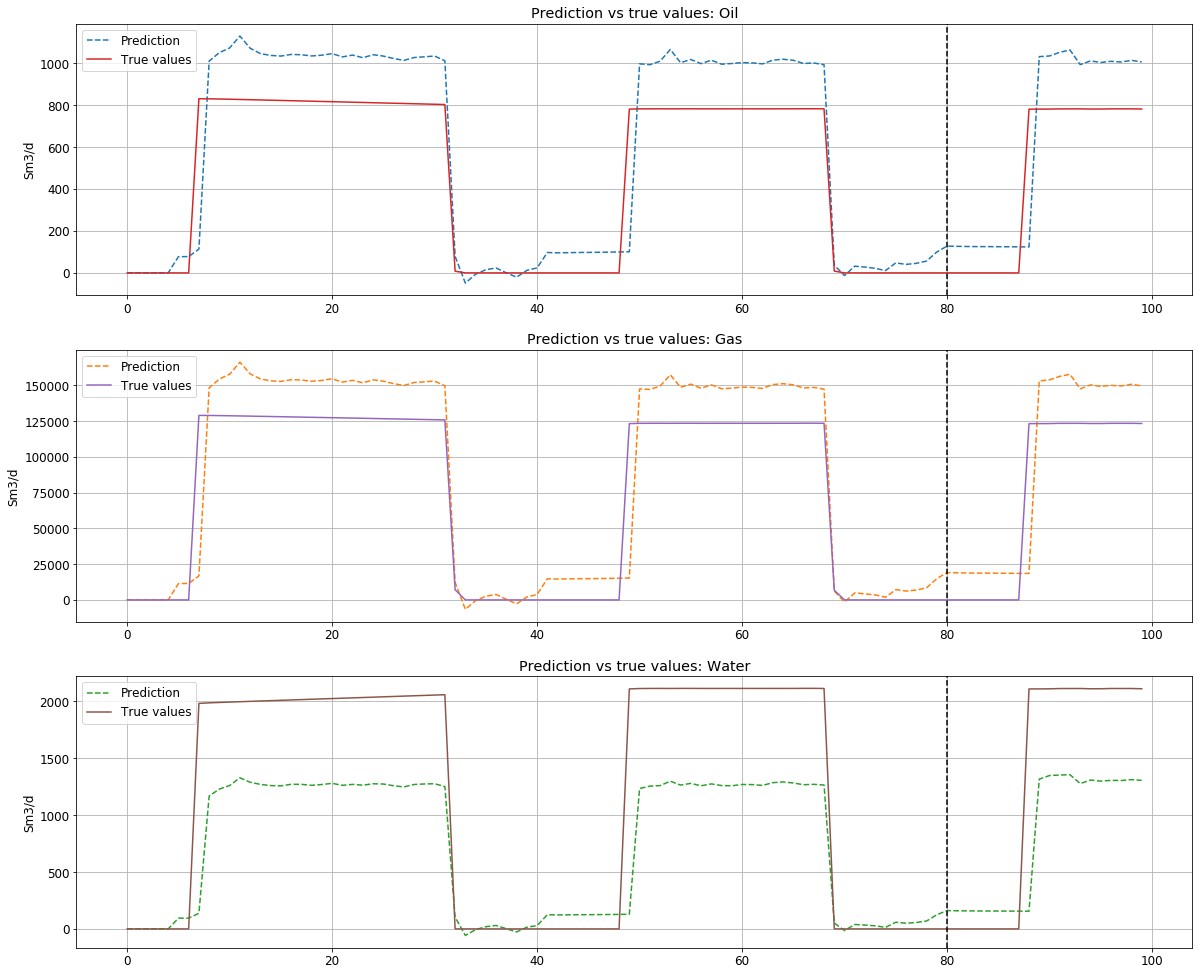

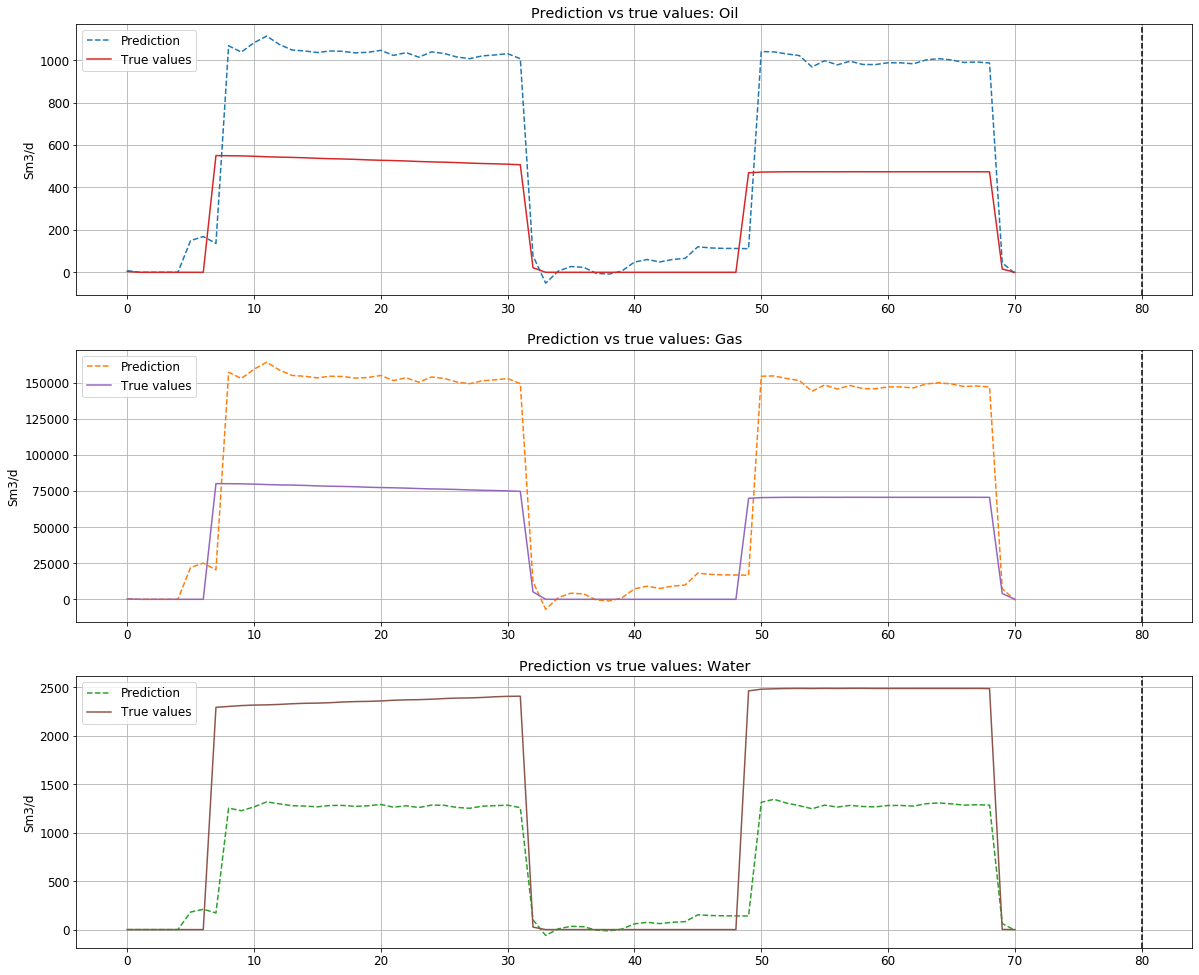

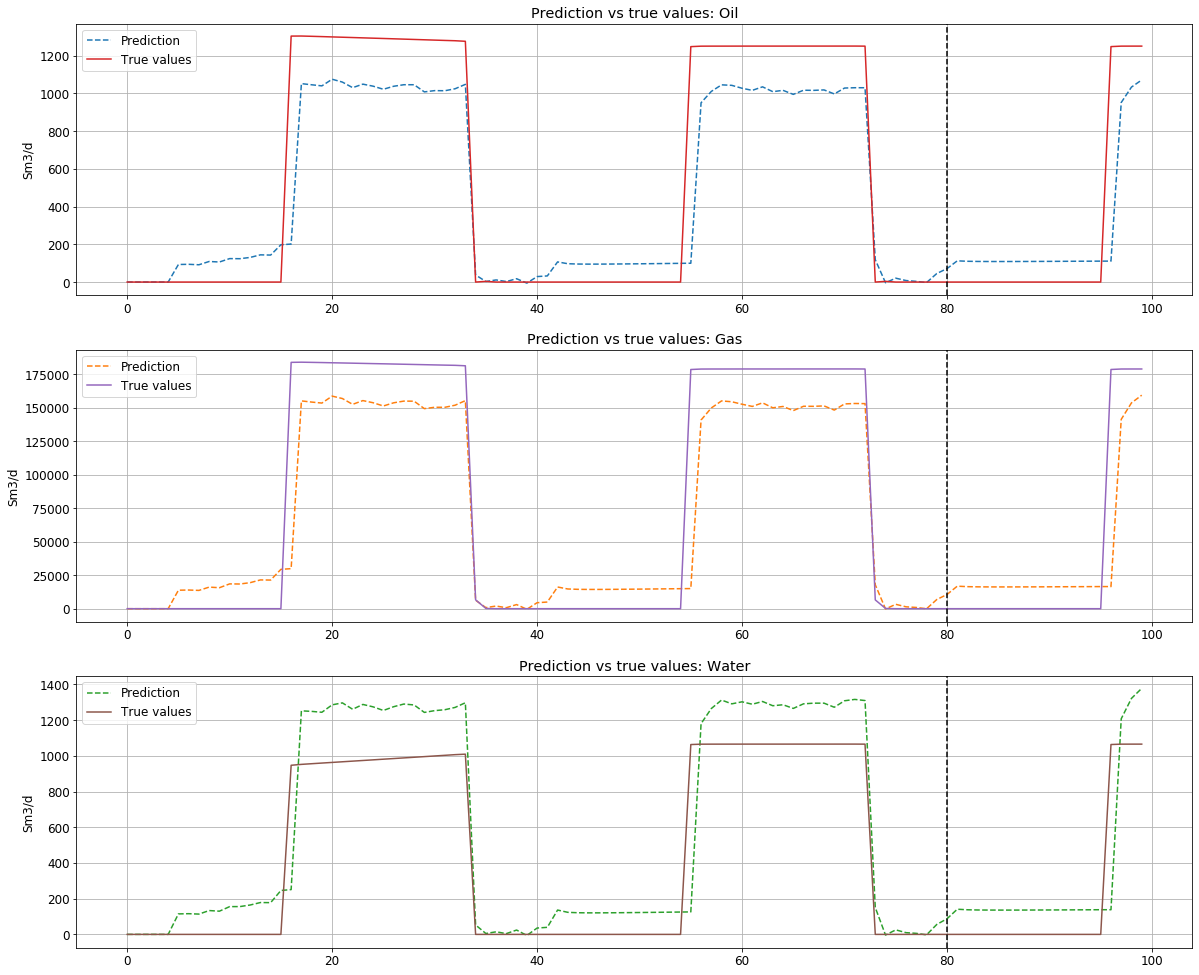

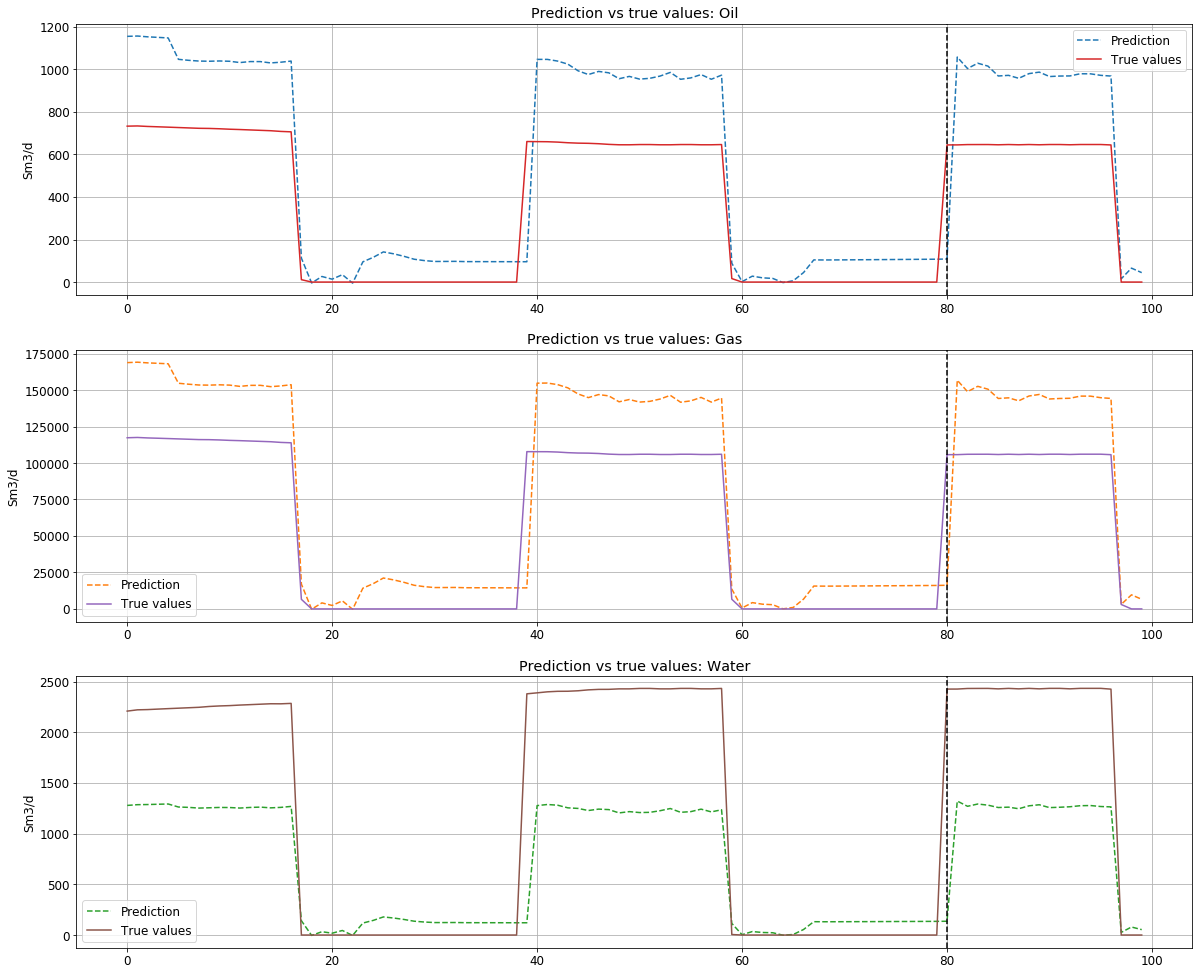

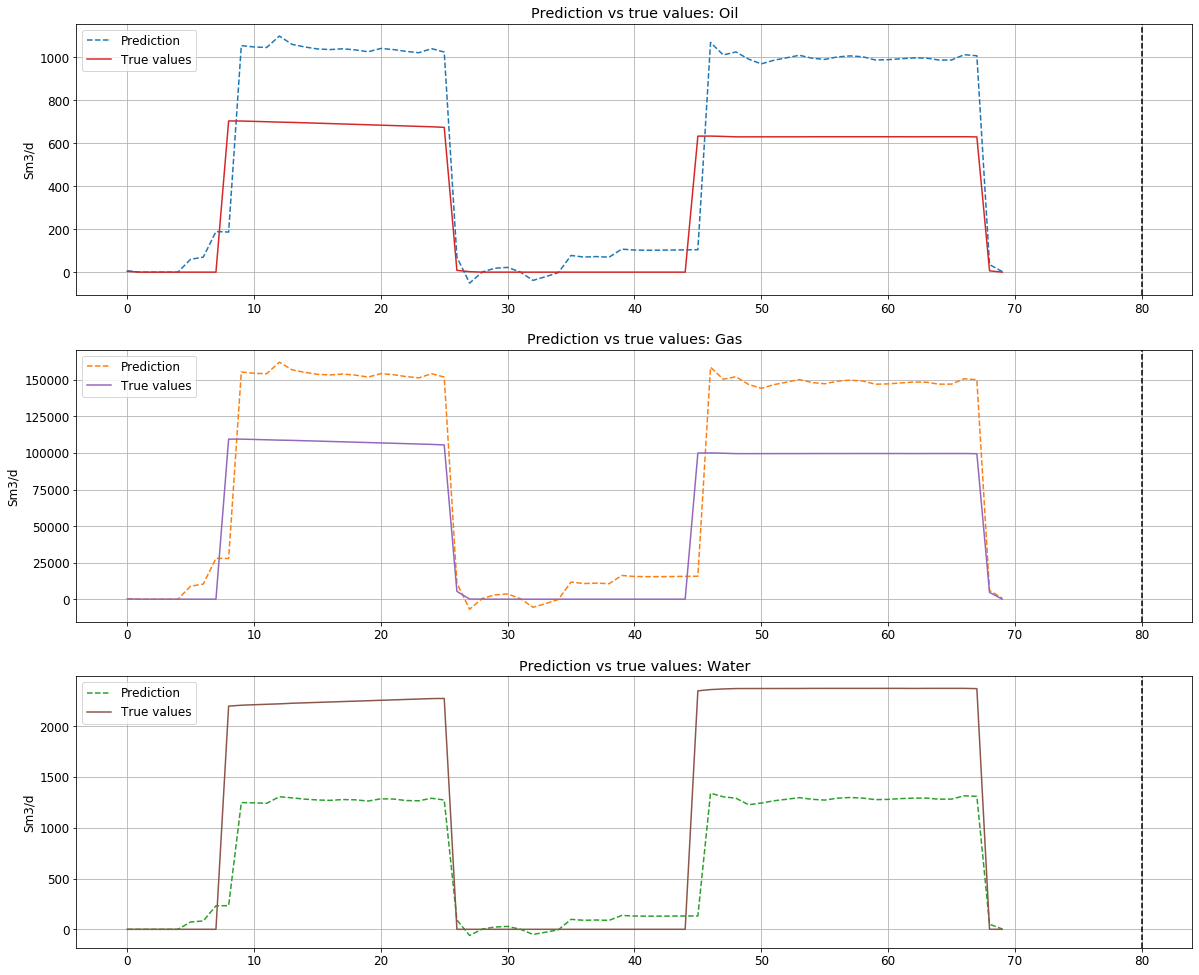

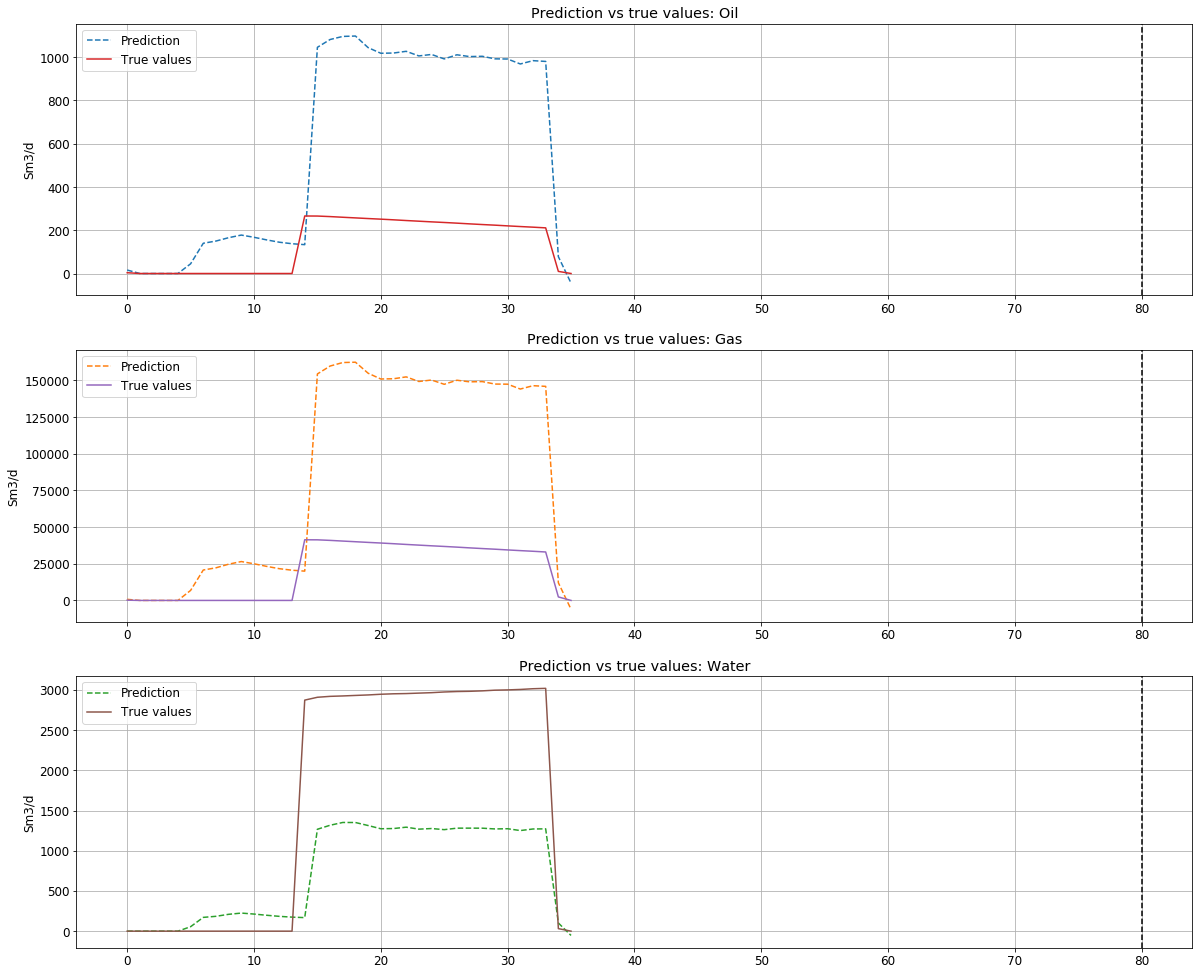

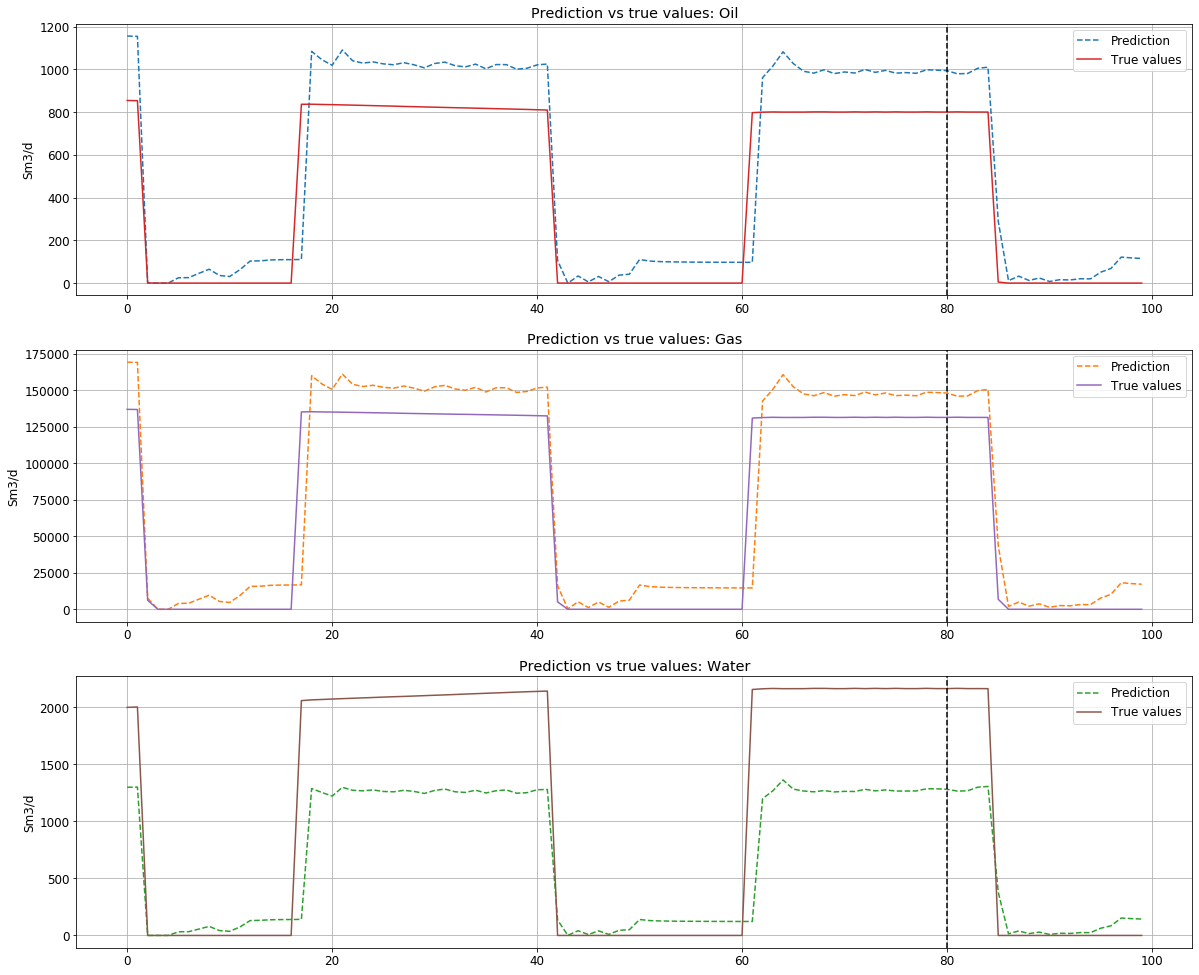

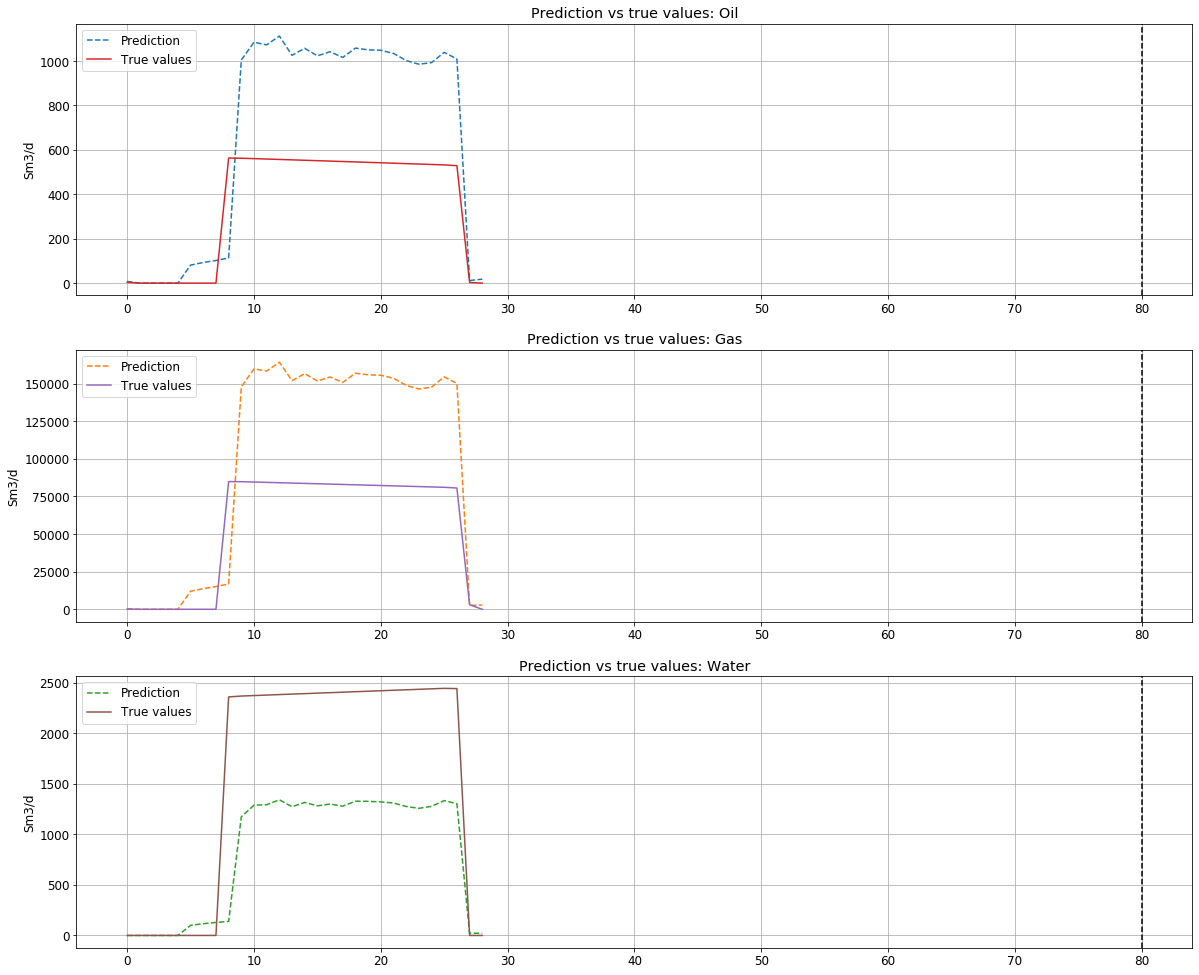

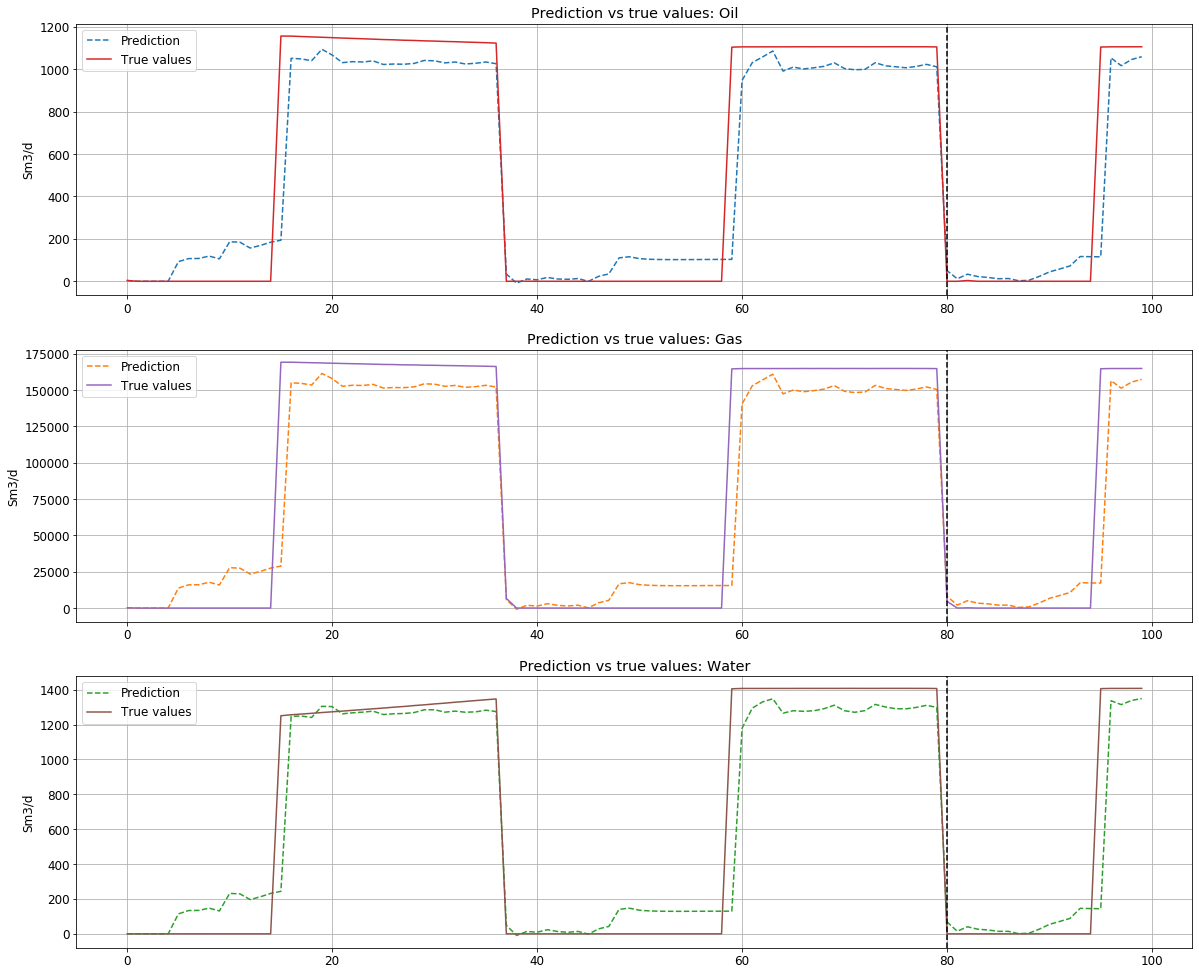

In [71]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped, verbose=0)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [50]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')

# XGB

In [36]:
MODEL_NAME = 'XGB-1'
LOSS = 'mse'

In [49]:
if 'MLP' in MODEL_NAME:
    lr = 1e-4
    n_epochs = 500
    
    model = create_MLP_1(n_layers=3, n_neurons=100, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'LSTM' in MODEL_NAME:
    lr = 1e-2
    n_epochs = 40
    
    model = create_LSTM_1(n_layers=1, n_neurons=50, dropout=0.2)
    
    optimizer = optimizers.Adam(lr=lr)
    model.compile(loss=LOSS, optimizer=optimizer)
    
elif 'TCN' in MODEL_NAME: # does not work
    lr = 1e-3
    n_epochs = 500
    import tensorflow.keras.optimizers
    batch_x = 17
    model = create_TCN_1(batch_x=batch_x, batch_y=X_train_shuffle.shape[1], 
                         nb_filters=50, kernel_size=5, dilations=[1, 2], dropout_rate=0.2)
    
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='mse', optimizer=optimizer)

elif "XGB" in MODEL_NAME:
    model = MultiOutputRegressor(XGBRegressor(n_estimators=1000, max_depth=5, reg_alpha=1))

In [50]:
X_valid, y_valid = None, None
X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s = [], [], [], []

for i, (inputs, outputs) in enumerate(zip(inputss, outputss)):
    all_len = len(inputs)
    train_len = int(np.floor(len(outputs) * TRAIN_VAL_RATIO))
    val_len = (all_len - train_len) // 2
    
    # split a multivariate sequence into samples
    raw_seq1 = np.hstack((inputs[:train_len], outputs[:train_len])) # ins and outs - train
    val = np.hstack((inputs[train_len:train_len + val_len], outputs[train_len:train_len + val_len])) # ins and outs - val
    true_data = np.hstack((inputs, outputs)) # ins and outs - all

    # normalize the data
    scaler = MinMaxScaler()
    raw_seq1_norm = scaler.fit_transform(raw_seq1) # norm all
    val_norm = scaler.transform(val)
    true_data_norm = scaler.transform(true_data)
    X, y = split_sequence(raw_seq1_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_val, y_val = split_sequence(val_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    X_all, _ = split_sequence(true_data_norm, N_STEPS, N_FEATURES_IN, N_FEATURES_OUT)
    
    # flatten input, if needed
    if 'MLP' in MODEL_NAME or 'XGB' in MODEL_NAME:
        X_reshaped = X.reshape((X.shape[0], n_input))
        X_val_reshaped = X_val.reshape((X_val.shape[0], n_input))
        X_all_reshaped = X_all.reshape((X_all.shape[0], n_input))
    else:
        X_reshaped = X
        X_val_reshaped = X_val
        X_all_reshaped = X_all
                
    # append
    if i == 0:
        X_train = X_reshaped
        y_train = y
        X_total = X_all_reshaped
    elif i < len(dfs) - 10:
        X_train = np.vstack((X_train, X_reshaped))
        y_train = np.vstack((y_train, y))
        X_total = np.vstack((X_total, X_all_reshaped))
        
        if X_val_reshaped.shape[0] != 0:
            if X_valid is None:
                X_valid = X_val_reshaped
                y_valid = y_val
            else:
                X_valid = np.vstack((X_valid, X_val_reshaped))
                y_valid = np.vstack((y_valid, y_val))
    else:
        X_all_reshaped_s.append(X_all_reshaped)
        raw_seq1_norm_s.append(raw_seq1_norm)
        true_data_norm_s.append(true_data_norm)
        true_data_s.append(true_data)
        
X_train_shuffle, y_train_shuffle = shuffle(X_train, y_train)

In [51]:
def scheduler(epoch, lr):
    if epoch < 25:
        return 1e-3
    if epoch < 50:
        return 1e-4
    elif epoch < 100:
        return 1e-5
    else:
        return 1e-6

callback = LearningRateScheduler(scheduler)

In [52]:
# train the model
start_time = time.time()
if 'TCN' in MODEL_NAME:
    shape_train = X_train_shuffle.shape[0] - X_train_shuffle.shape[0]%batch_x
    shape_test = X_valid.shape[0] - X_valid.shape[0]%batch_x
    model_inf = model.fit(X_train_shuffle[:shape_train], y_train_shuffle[:shape_train], epochs=n_epochs, verbose=1, validation_data=(X_valid[:shape_test], y_valid[:shape_test]))
elif 'XGB' in MODEL_NAME:
    model.fit(X_reshaped, y)
else:
    if X_valid.shape[0] > 0:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, callbacks=[callback], batch_size=128, validation_data=(X_valid, y_valid))
    else:
        model_inf = model.fit(X_train_shuffle, y_train_shuffle, epochs=n_epochs, verbose=1, batch_size=64)  

delta_time = time.time() - start_time
cur_time = datetime.datetime.now()

C:\Users\Asus\Anaconda3\lib\site-packages\xgboost\data.py:96: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [53]:
if 'XGB' not in MODEL_NAME:
    loss = model_inf.history['loss']
    val_loss = model_inf.history['val_loss']

    plot_train_val_loss(loss, val_loss, model_name=MODEL_NAME)

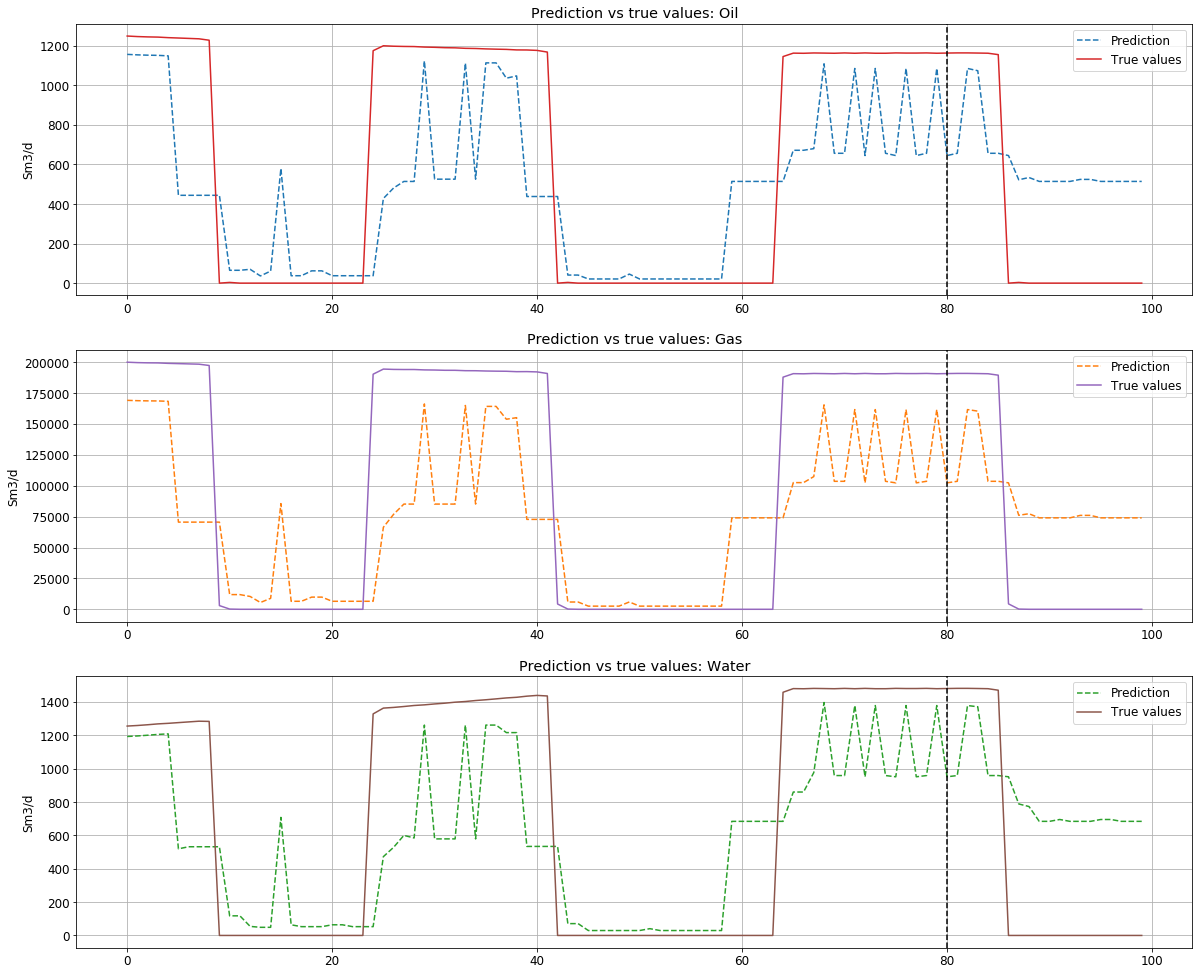

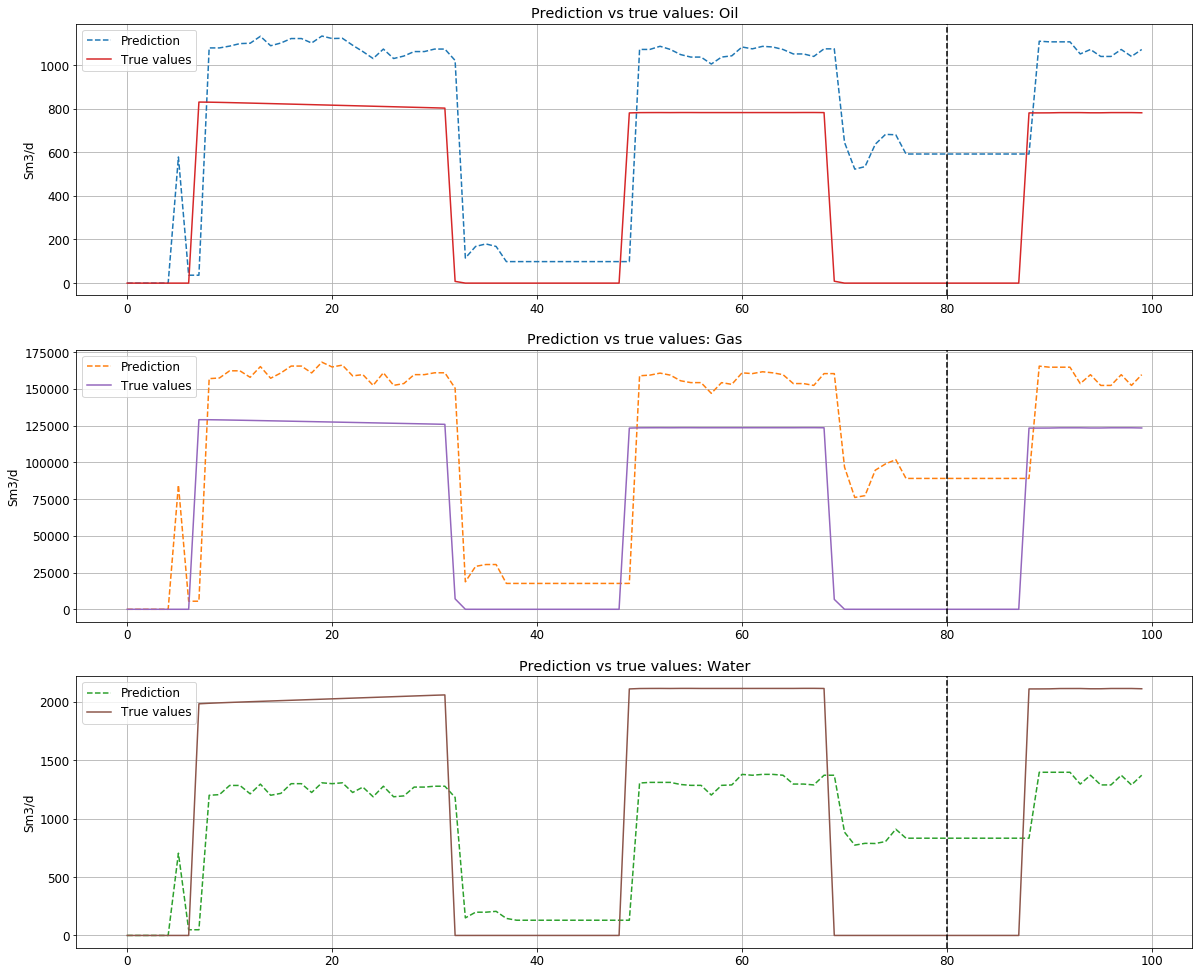

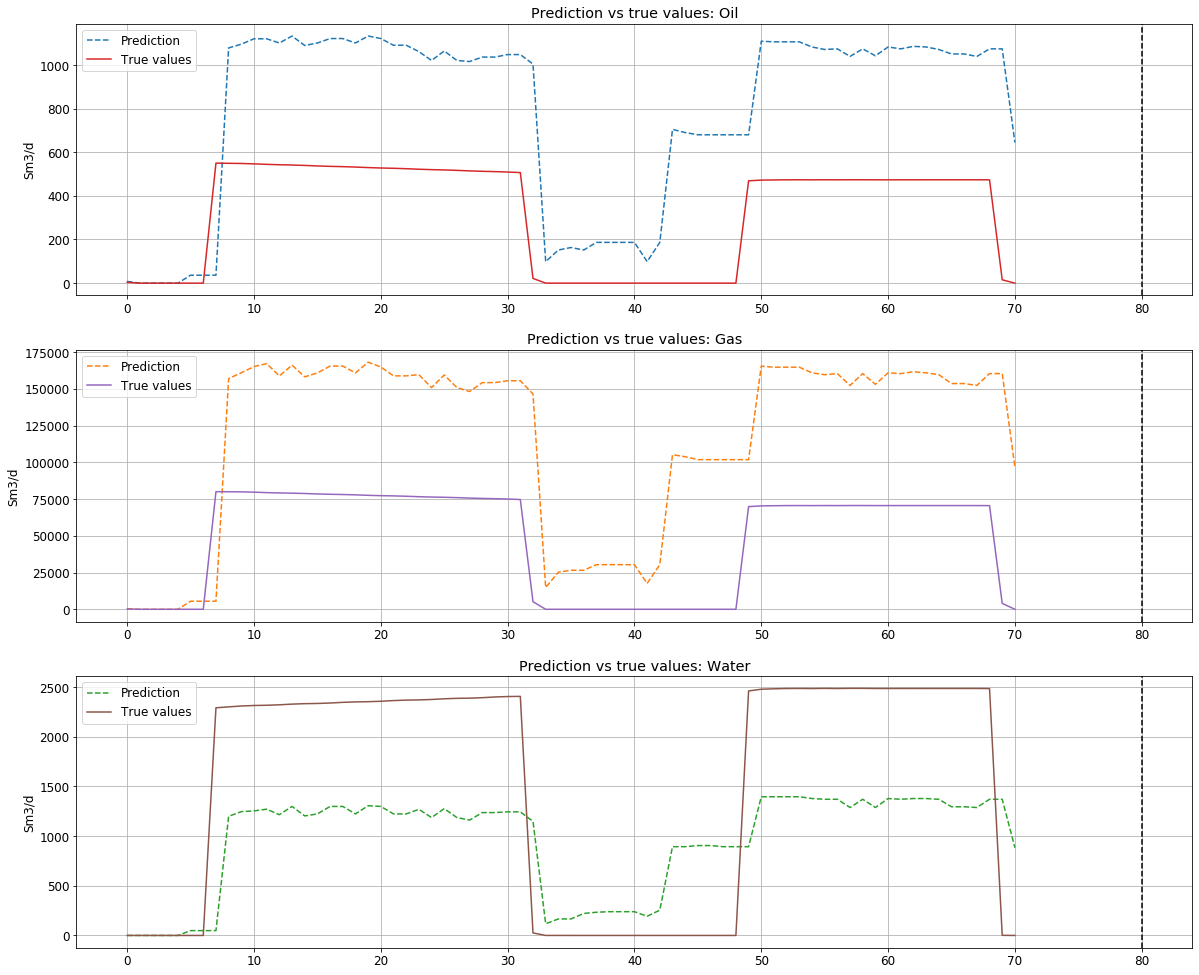

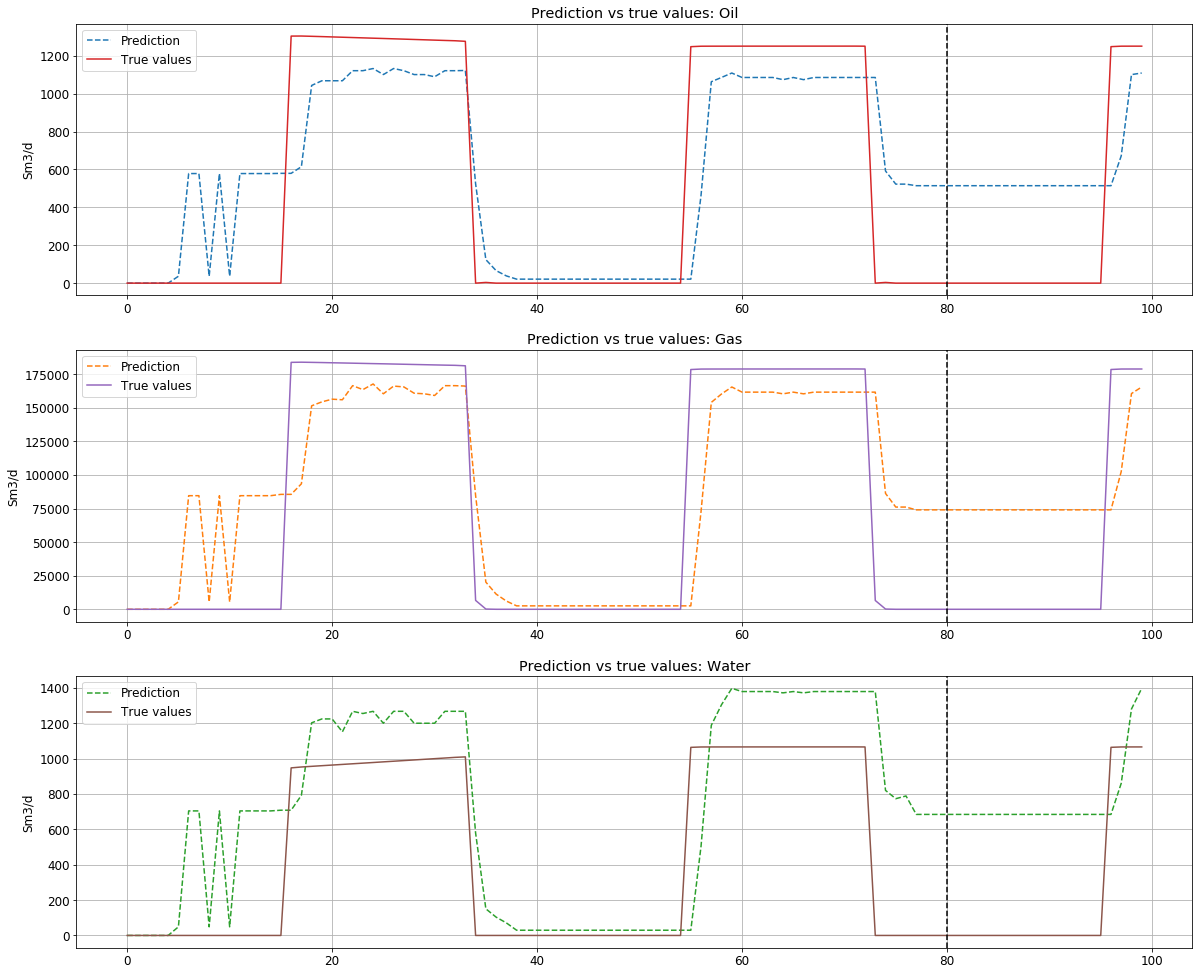

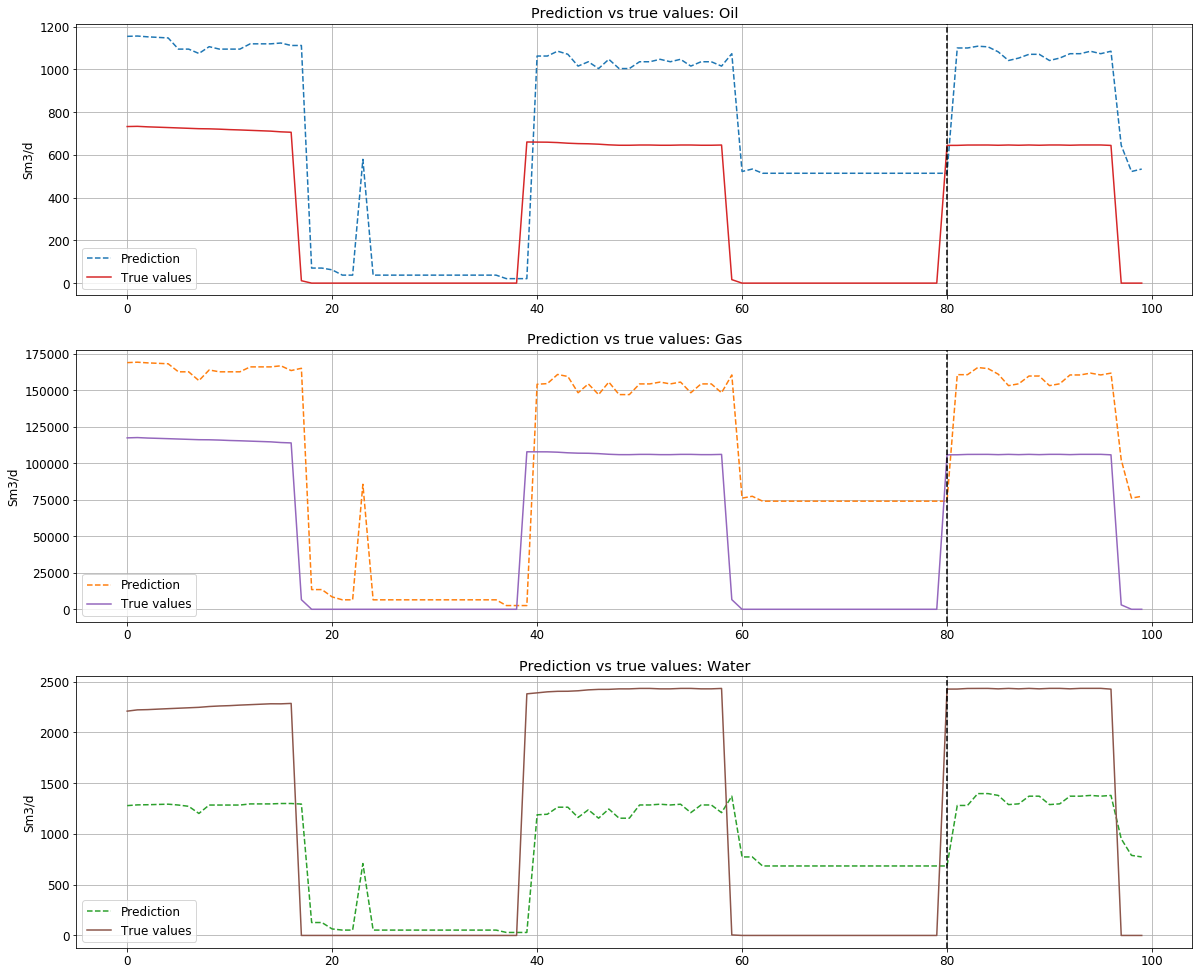

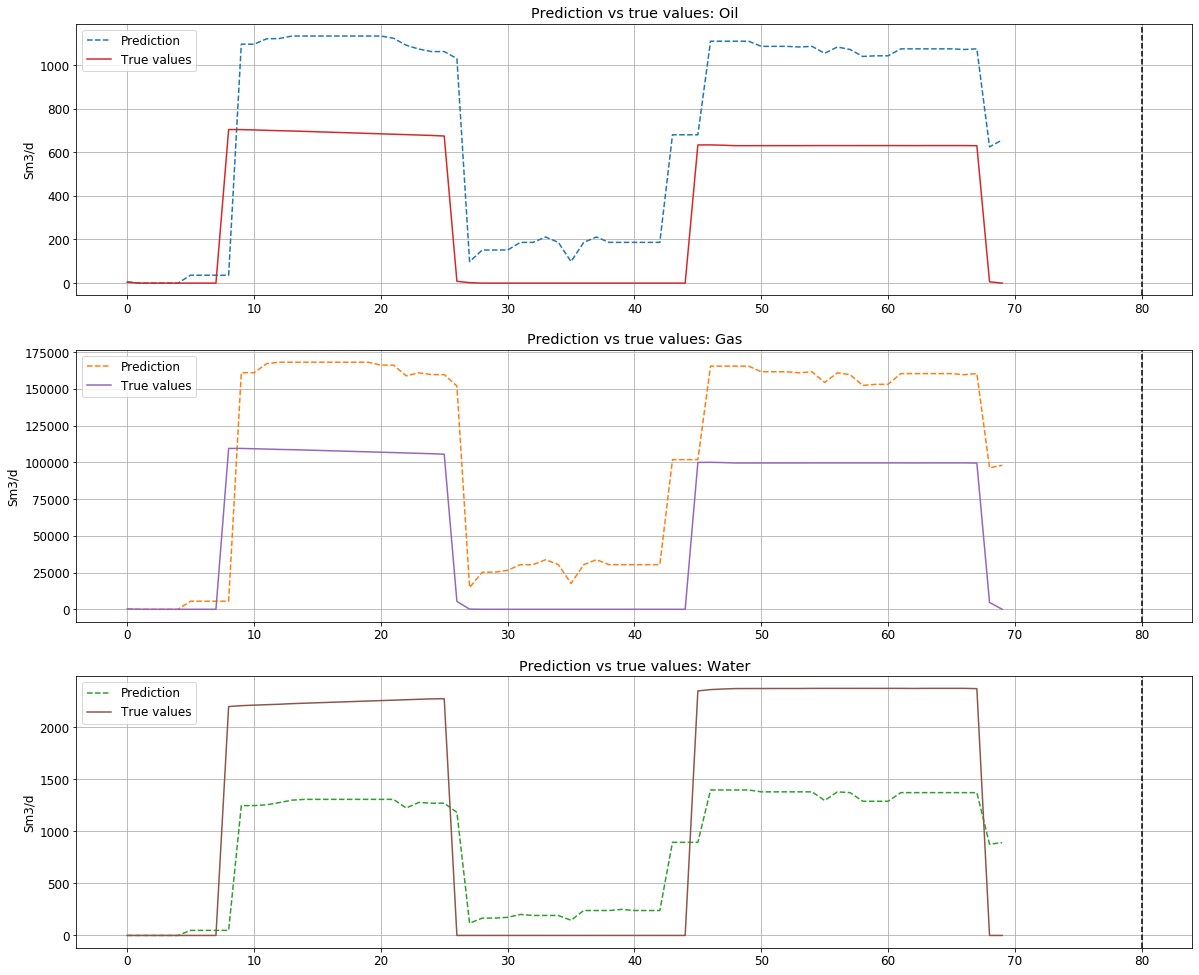

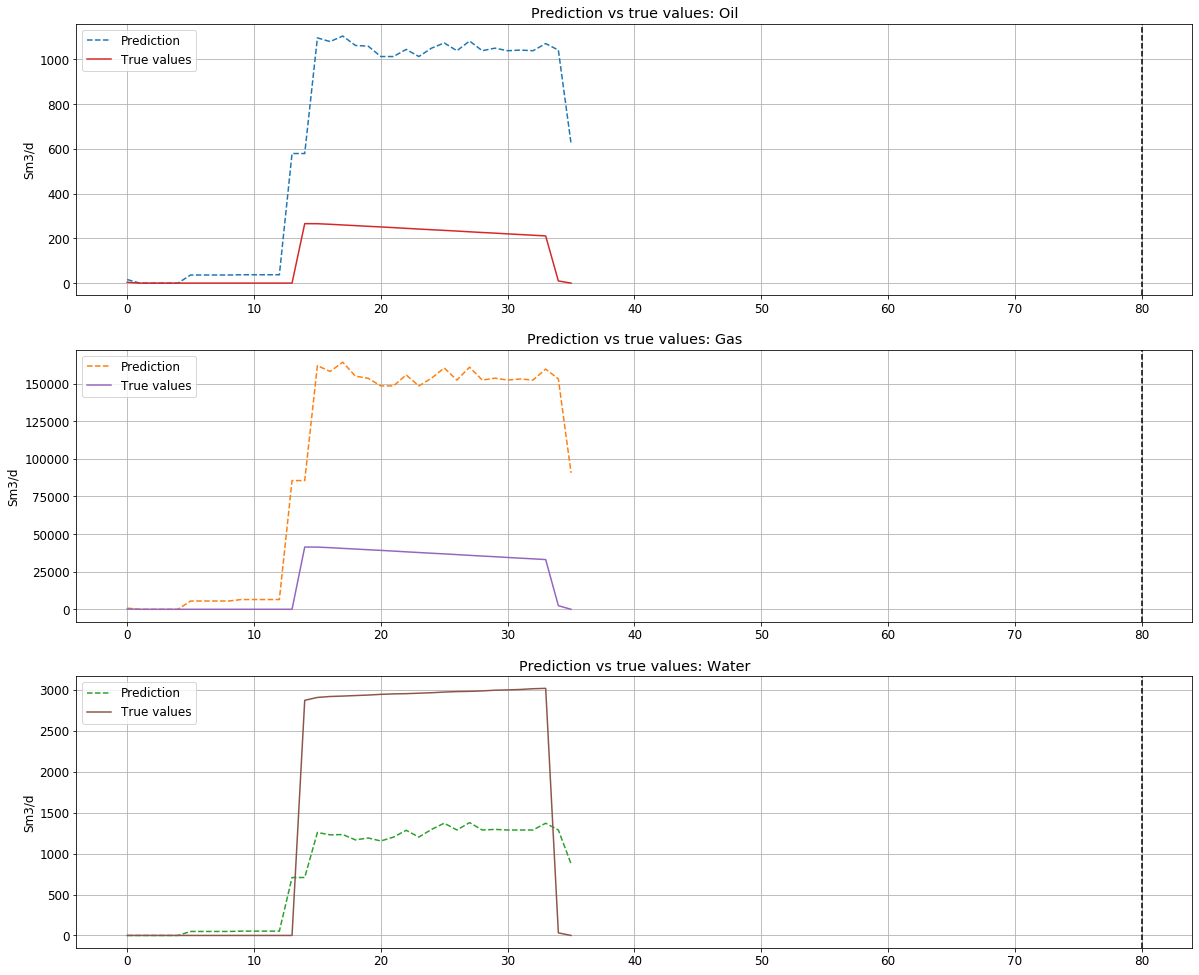

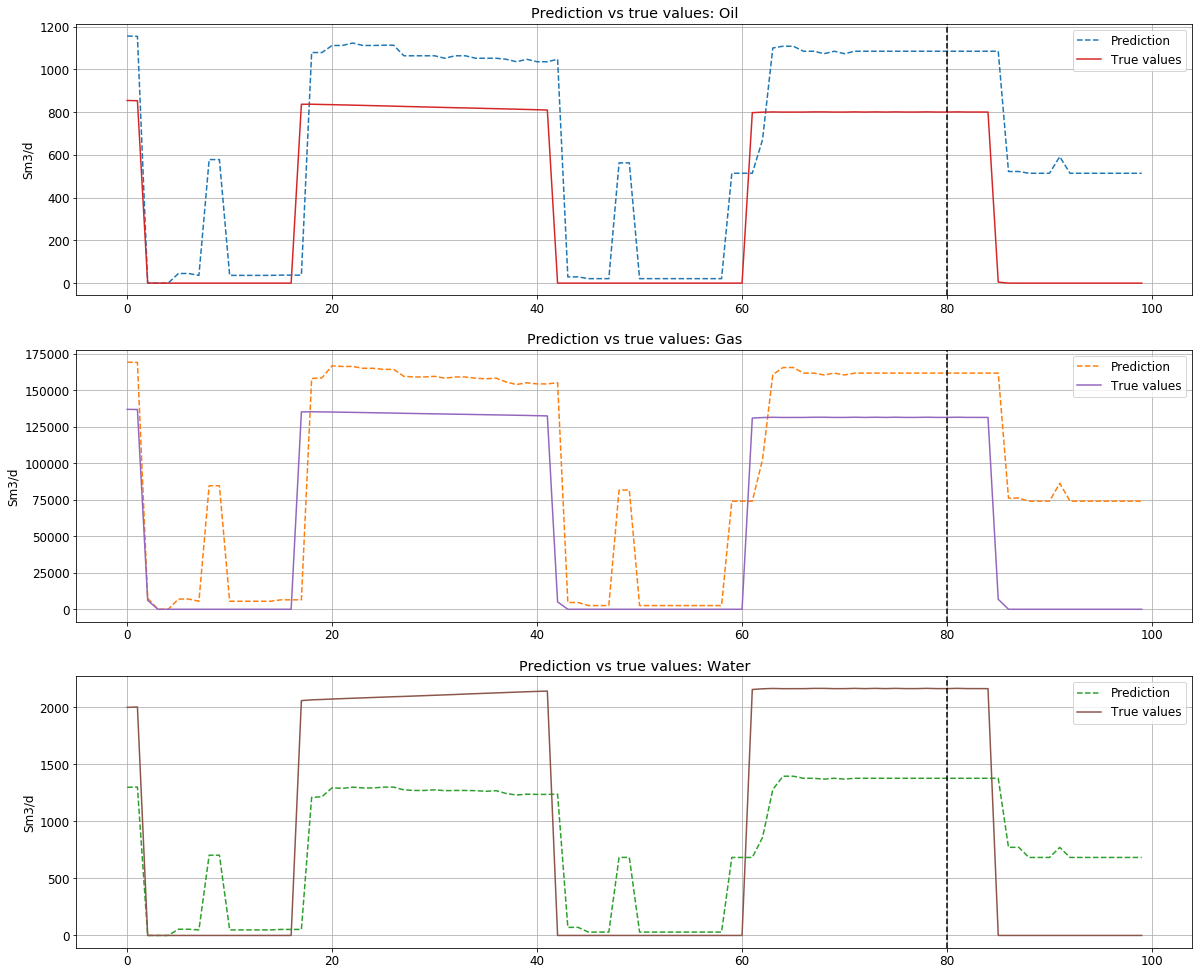

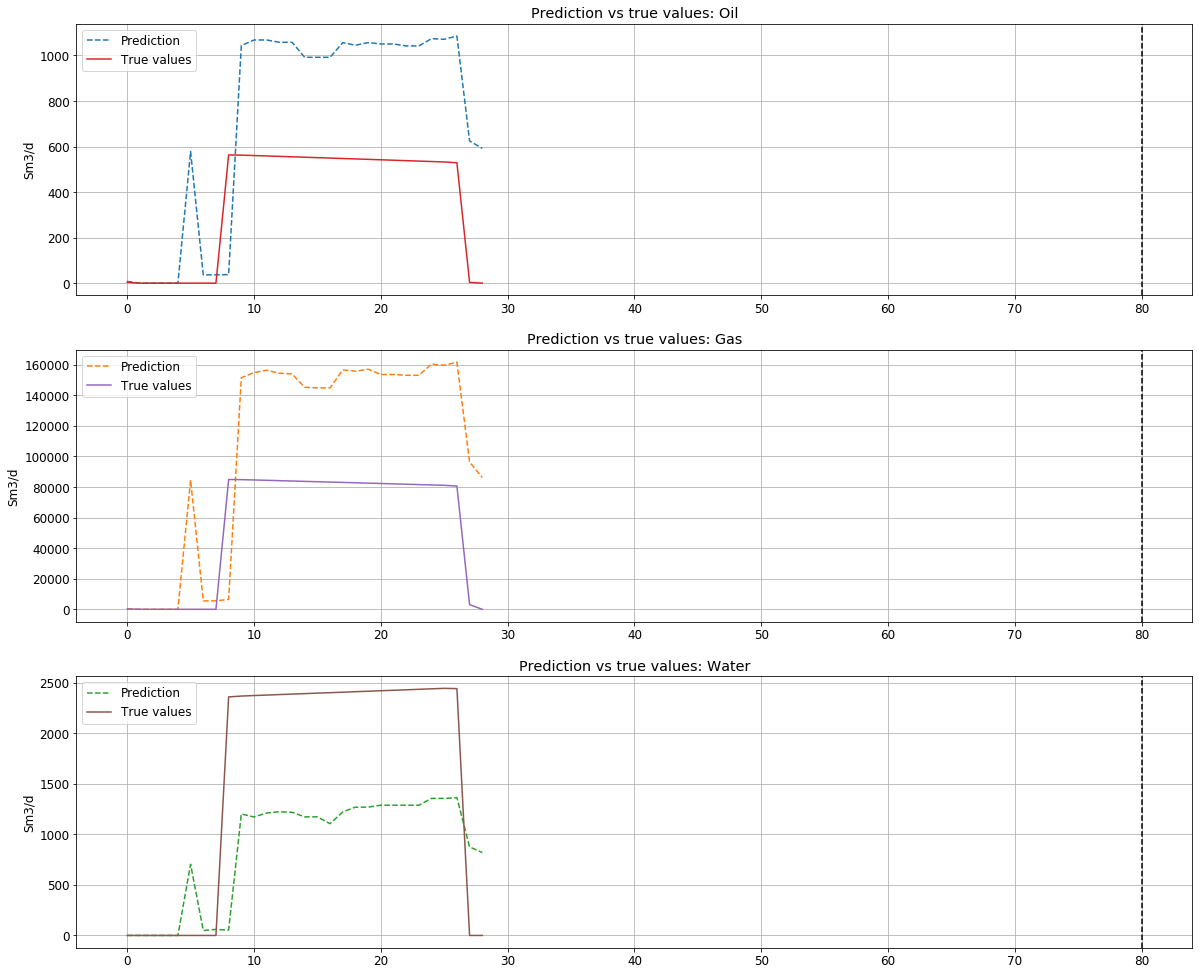

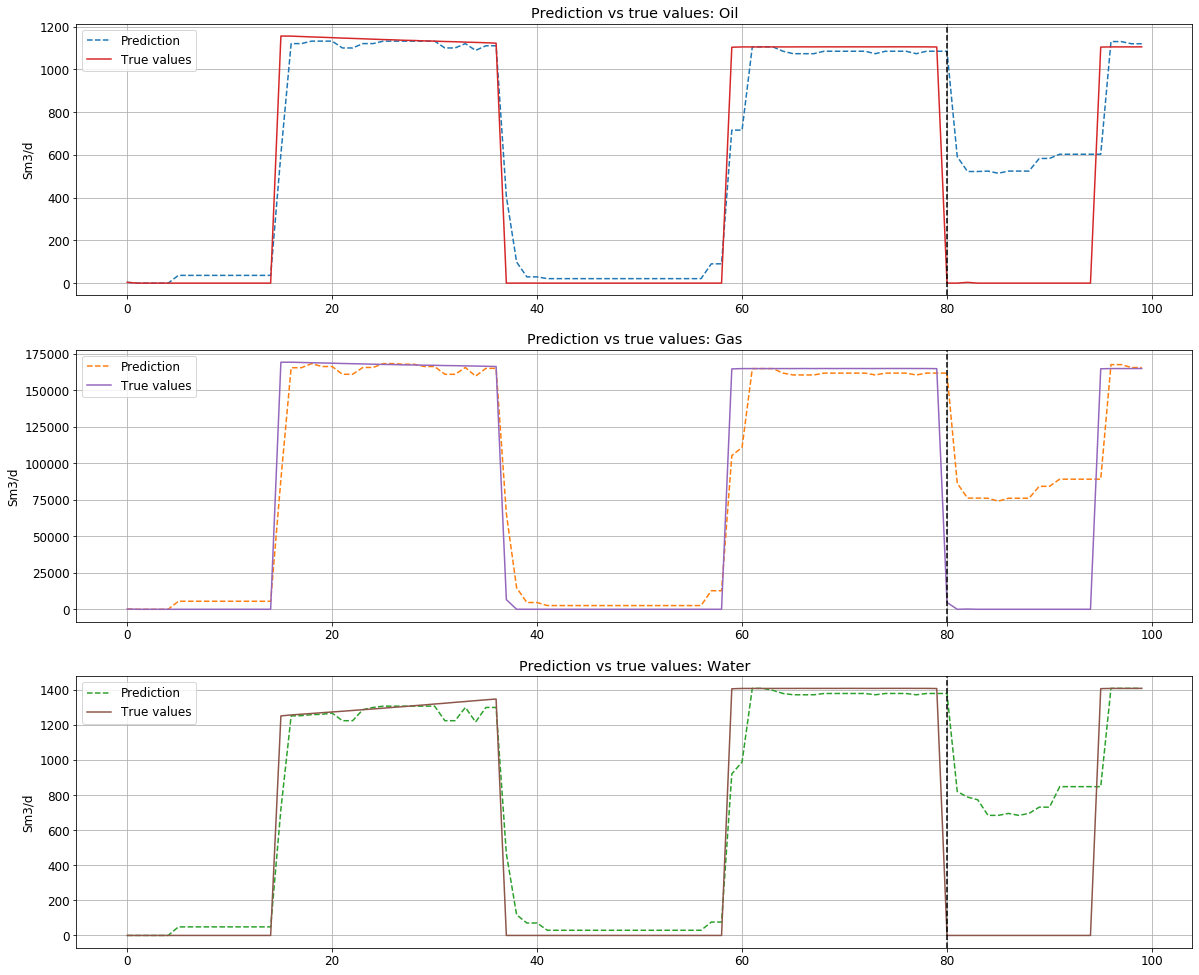

In [54]:
for X_all_reshaped, raw_seq1_norm, true_data_norm, true_data in zip(X_all_reshaped_s, raw_seq1_norm_s, true_data_norm_s, true_data_s):
    # obtain the model results: make a prediction and calculate an error
    y_pred_norm = model.predict(X_all_reshaped)
    table_norm = np.hstack((true_data_norm[:, :-N_FEATURES_OUT], np.vstack((raw_seq1_norm[:N_STEPS, -N_FEATURES_OUT:], y_pred_norm))))
    table = scaler.inverse_transform(table_norm) # denormalize all
    preds = table[:, -N_FEATURES_OUT:]
    errs = error(preds, true_data[:, -N_FEATURES_OUT:]) # calc error between denormalized y_pred and real y

    data = {}
    data["model_name"] = MODEL_NAME
    data["train_size"] = train_len
    data["preds"] = preds.tolist()
    data["g_truth"] = true_data[:, -N_FEATURES_OUT:].tolist()
    data["errors"] = errs.tolist()
    data["training_time"] = delta_time
    data["cur_time"] = str(cur_time)

#     print_results(data)
    plot_pred(data)

### Save the model and params

In [46]:
if 'XGB' in MODEL_NAME:
    pickle.dump(model, open(f'{STUDY_PATH}/{MODEL_NAME}.hdf', "wb"))
elif 'TCN' in MODEL_NAME:
    # get model as json string and save to file
    model_as_json = model.to_json()
    with open(f'{STUDY_PATH}/{MODEL_NAME}.json', "w") as json_file:
        json_file.write(model_as_json)
        
    # save weights to file (for this format, need h5py installed)
    model.save_weights(f'{STUDY_PATH}/{MODEL_NAME}.h5')
else:
    model.save(f'{STUDY_PATH}/{MODEL_NAME}.hdf')